---
---

# Difference Spec Code for SDSS and SAMI Spectra

---
---

## Imports

In [131]:
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import pylab as py
import numpy as np
import scipy as sp
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.integrate import simpson
from scipy.ndimage import gaussian_filter1d
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
from astropy.constants import c
from astropy.cosmology import Planck18 as cosmo 
import spectres
from PyAstronomy import pyasl
from lmfit.models import GaussianModel

## Constants

In [231]:
OIII_1 = 4960.30
OIII_2 = 5008.24
NII_1 = 6549.85
NII_2 = 6585.28
SII_1 = 6718.29
SII_2 = 6732.67
H_ALPHA = 6564.61
H_BETA = 4862.68

#TODO: get actual values for these
ATLAS_O_BAND_WIDTH = 2900
ATLAS_O_BAND_LAM = 6900
ZTF_I_BAND_WIDTH = 1100
ZTF_I_BAND_LAM = 7500
ASSASN_V_BAND_WIDTH = 1500
ASSASN_V_BAND_LAM = 5500
ASSASN_G_BAND_WIDTH = 1500
ASSASN_G_BAND_LAM = 4700
#

c_km_s = 2.99792458e5 # km/s
c_m_s = 2.99792458e8 # m/s
c_ang_s = 2.99792458e18 # Ang/s
EPS = 1e-8
LINEWIDTH = 0.5
LAMBDAS_TO_IGNORE_WIDTH = 180
BALMER_DECREMENT_VEL_WIDTH = 4000
FIGURE_SIZE = (10,4)
#TODO: remove testing
SMOOTH_FACTOR = 1.0
#

FNAME_2015_BLUE_4ARCSEC = "323854_A_spectrum_4-arcsec_blue.fits"
FNAME_2015_RED_4ARCSEC = "323854_A_spectrum_4-arcsec_red.fits"
# OLD_SFD_Y_AX_LABEL = "10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹"
SFD_Y_AX_LABEL = r"Spectral flux density ($10^{-17}$ erg $\text{s}^{-1}$ $\text{cm}^{-2}$ $\AA^{-1}$)"

z = 0.0582 # for spectroscopy
z_lum = 0.05938

# From 2021 "The SAMI Galaxy Survey: the third and final data release"
"""
                                For the SAMI survey, we used the
580V and 1000R gratings, delivering a wavelength range of 3750-
5750 and 6300-7400 Å for the blue and red arms, respectively. The
spectral resolutions are R = 1808 and 4304 for the blue and red
arms, equivalent to an effective velocity dispersion of σ of 70.4 and
29.6 km s^{-1}, respectively
""";

RES_15_BLUE = 1808
RES_15_RED = 4304

# From 2014 "The SAMI Galaxy Survey: instrument specification and target selection"
"""
                                SAMI feeds the AAOmega spectrograph
(Sharp et al. 2006), which for the survey is set up to have resolu-
tions of R = 1730 in the blue arm and R = 4500 in the red arm.
""";

# R_15_blue = 1730
# R_15_red = 4500

# Average across all epochs and wavelength ranges
# SDSS_res = 2000
                                                                                #this marks 80 characters

## Reading functions
slightly edited versions of the original functions from Scott + extras

In [133]:
def sami_read_apspec(
    filename: str,
    extname: str,
    var_extname: str,
    doareacorr: bool = False,
    bugfix: bool = True
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    hdulist = fits.open(filename)
    sami_flux = hdulist[extname].data
    header = hdulist[extname].header
    crval1=header['CRVAL1']
    cdelt1=header['CDELT1']
    crpix1=header['CRPIX1']
    naxis1=header['NAXIS1'] 
    x=np.arange(naxis1)+1
    L0=crval1-crpix1*cdelt1 #Lc-pix*dL        
    sami_lam = L0+x*cdelt1

    if (doareacorr):
        # fix bug in ap spec code:
        if (bugfix):
            areacorr=areacorr/2.0
        areacorr = header['AREACORR']
        sami_flux = sami_flux * areacorr

    #TODO: remove testing
    # print(header['BUNIT'])
    #

    #convert SAMI (wavelength in air) to wavelength in vacuum By default, the conversion specified by Ciddor 1996 are used.
    samivac_lam = pyasl.airtovac2(sami_lam)
    
    sami_flux *= 10 # flux unit conversion from 10e16 to 10e17 to match sdss

    
    sami_var = hdulist[var_extname].data #extract the variance array
    hdulist.close()
    return sami_flux, samivac_lam, sami_var

def sdss_read(
    infile: str, return_wresl: bool = True
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:

    # get basic info on file:
    
    # opening file
    hdulist = fits.open(infile)
    hdr0 = fits.getheader(infile)
    hdr1 = hdulist['COADD'].header

    #TODO: remove testing
    # try:
    #     print(hdr0['BUNIT'])
    # except:
    #     print(f"no BUNIT in file {infile}")
    #

    # read spectrum from COADD extension:
    sdss_spec_table = hdulist['COADD'].data
    sdss_flux = sdss_spec_table['flux']
    sdss_loglam = sdss_spec_table['loglam']

    # SDSS spectra are in log wavelength bins, to convert to linear:
    sdss_lam = 10.0**sdss_loglam
    # inverse variance
    sdss_ivar = sdss_spec_table['ivar']

    # close fits file:
    hdulist.close()

    # define parts of spectrum where data is likely to be good:
    idx = np.where((sdss_lam>3900) & (sdss_lam<9000))
    sdss_flux = sdss_flux[idx]
    sdss_lam = sdss_lam[idx]
    sdss_ivar = sdss_ivar[idx]
    if return_wresl:
        wresl = sdss_spec_table['wresl']
        wresl = wresl[idx]
        return sdss_flux, sdss_lam, sdss_ivar, wresl
    else:
        return sdss_flux, sdss_lam, sdss_ivar

In [134]:
def gaussian_blur_before_resample(
    low_res: np.ndarray | float, 
    high_res: np.ndarray | float, 
    lam_low_res: np.ndarray,            # should always be lam01?
    lam_high_res: np.ndarray,
    flux_high_res: np.ndarray,
    n_chunks: int = 100
) -> np.ndarray:
    """
    Gaussian blur using resolution (R = λ/FWHM) arrays.
    Degrades high_res spectrum to match low_res spectrum.
    """
    # Compute sigma arrays on their native grids
    sigma_low_res_arr = (lam_low_res / low_res) / 2.355
    
    sigma_high_res_arr = (lam_high_res / high_res) / 2.355

    #TODO: remove testing
    diffs = np.diff(lam_high_res)
    # print(f"Min step: {diffs.min()}, Max step: {diffs.max()}, Std/Mean: {diffs.std()/diffs.mean()}")
    n_smoothed = 0
    n_ignored = 0
    #

    blurred = flux_high_res.copy()
    chunk_size = len(lam_high_res) // n_chunks
    
    for i in range(n_chunks):
        high_res_chunk_start_idx = i * chunk_size
        high_res_chunk_end_idx = (i + 1) * chunk_size if i < n_chunks - 1 else len(lam_high_res)
        
        # Wavelength range for this chunk (on the high_res grid)
        lam_high_res_chunk = lam_high_res[high_res_chunk_start_idx:high_res_chunk_end_idx]
        lam_min = lam_high_res_chunk[0]
        lam_max = lam_high_res_chunk[-1]
        
        # Find low_res wavelengths that fall in this range
        low_res_lam_chunk_mask = (lam_low_res >= lam_min) & (lam_low_res <= lam_max)
        


        if np.any(low_res_lam_chunk_mask):
            # Compute median sigma in this chunk for both spectra
            sigma_low_res_chunk = sigma_low_res_arr[low_res_lam_chunk_mask]
            sigma_high_res_chunk = sigma_high_res_arr[high_res_chunk_start_idx:high_res_chunk_end_idx]
            sigma_low_res_median = np.median(sigma_low_res_chunk)
            sigma_high_res_median = np.median(sigma_high_res_chunk)

            #TODO: remove testing
            diffs = np.diff(lam_high_res_chunk)
            # print(f"\nChunk {i+1}\nMin step: {diffs.min()}, Max step: {diffs.max()}, Std/Mean: {diffs.std()/diffs.mean()}")
            #


            wavelength_step = np.median(np.diff(lam_high_res_chunk))

            # Note: should be median(sqrt(sigma_low^2 - sigma_high^2)) but
            # sqrt(median(sigma_low)^2 - median(sigma_high)^2) is a good approximation
            # since sigma_low and sigma_high are approximately constant across the chunk,
            # provided n_chunks is large enough.
            sigma_kernel_sq = sigma_low_res_median**2 - sigma_high_res_median**2

            #TODO: remove testing
            # If CV is small, values are approximately constant
            cv_low_res = np.std(sigma_low_res_chunk) / np.median(sigma_low_res_chunk)
            cv_high_res = np.std(sigma_high_res_chunk) / np.median(sigma_high_res_chunk)
            # Rule of thumb: CV < 0.05-0.10 means "approximately constant"
            # print(f"CV low res: {cv_low_res}, CV high res: {cv_high_res}")

            # Fractional spread within chunk
            spread_low = (np.max(sigma_low_res_chunk) - np.min(sigma_low_res_chunk)) / np.median(sigma_low_res_chunk)
            spread_high = (np.max(sigma_high_res_chunk) - np.min(sigma_high_res_chunk)) / np.median(sigma_high_res_chunk)
            # print(f"Spread low res: {spread_low}, Spread high res: {spread_high}")
            #

            if sigma_kernel_sq > EPS:
                #TODO: remove testing
                # print(f"sigma_kernel_sq: {sigma_kernel_sq}", flush=True)
                n_smoothed += 1
                #
                sigma_pix = np.sqrt(sigma_kernel_sq) / wavelength_step
                temp_blurred = gaussian_filter1d(flux_high_res, sigma=sigma_pix)
                blurred[high_res_chunk_start_idx:high_res_chunk_end_idx] = temp_blurred[high_res_chunk_start_idx:high_res_chunk_end_idx]
            #TODO: remove testing
            else:
                # print(f"too small sigma_kernel_sq: {sigma_kernel_sq}")
                # print(f"\tNo blurring applied in chunk {i+1}", flush=True)
                n_ignored += 1
            #
        else:
            raise ValueError("No low_res coverage in this chunk. This should never happen.")
    
    #TODO: remove testing
    # print(f"n_smoothed: {n_smoothed}, n_ignored: {n_ignored}")
    #
    return blurred

In [135]:
def gaussian_blur_after_resampling(
    low_res: np.ndarray | float, 
    high_res: np.ndarray | float, 
    lam: np.ndarray,
    flux_high_res: np.ndarray, 
    wavelength_step: float, 
    n_chunks: int = 20
) -> np.ndarray:
    """
    Gaussian blur using resolution (R = λ/FWHM) arrays.
    Degrades high_res spectrum to match low_res spectrum.
    
    Handles the case where high_res <= low_res at some wavelengths
    (no blurring needed there).
    """
    if np.isscalar(low_res):
        low_res = np.full_like(lam, low_res)
    if np.isscalar(high_res):
        high_res = np.full_like(lam, high_res)

    fwhm_low_res = lam / low_res
    fwhm_high_res = lam / high_res

    sigma_low_res = fwhm_low_res / 2.355
    sigma_high_res = fwhm_high_res / 2.355
    
    # Calculate the kernel sigma needed to convolve high_res to low_res
    # If high_res is already lower resolution, no blurring needed (set to 0)
    sigma_diff_sq = sigma_low_res**2 - sigma_high_res**2
    sigma_diff_sq = np.maximum(sigma_diff_sq, 0)  # Clamp negative values to 0
    sigma_kernel_arr = np.sqrt(sigma_diff_sq)
    
    blurred = flux_high_res.copy()
    chunk_size = len(lam) // n_chunks
    
    for i in range(n_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i < n_chunks - 1 else len(lam)
        
        sigma_pix = np.median(sigma_kernel_arr[start:end]) / wavelength_step
        
        if sigma_pix > EPS:
            temp_blurred = gaussian_filter1d(flux_high_res, sigma=sigma_pix)
            #TODO: remove testing
            # plt.plot(lam, flux_high_res)
            # plt.plot(lam, temp_blurred)
            # plt.xlim((lam[start], lam[end-1]))
            # plt.show()
            #
            blurred[start:end] = temp_blurred[start:end]
        # else: keep original flux (already copied above)
    
    #TODO: remove testing
    # plt.plot(lam, flux_high_res)
    # plt.plot(lam, blurred)
    # plt.show()
    #

    return blurred

In [136]:
def get_lam_bounds(lam: float, width: float, is_rest_frame: bool = True) -> tuple[float, float]:
    if is_rest_frame:
        obs_lam = lam * (1+z)
    else:
        obs_lam = lam
    left = obs_lam - width / 2
    right = obs_lam + width / 2
    return left, right

In [137]:
def plot_vert_emission_lines(
    ions: dict[str, float] | None, 
    plot_x_bounds: tuple[float, float] | None = None,
    fill_between_bounds: tuple[float, float] | None = None,
    fill_between_label: str | None = None,
    fill_between_opacity: float = 0.5,
    vlines_cmap: Colormap | None = plt.cm.tab10,
    is_rest_frame: bool = True,
) -> None:
    if ions is None:
        return
    for i, (name, lam) in enumerate(ions.items()):
        if is_rest_frame:
            obs_lam = lam * (1+z)
        else:
            obs_lam = lam
        if plot_x_bounds is None or (plot_x_bounds[0] < obs_lam < plot_x_bounds[1]):
            plt.axvline(
                obs_lam, linestyle='--', lw=LINEWIDTH,
                color=vlines_cmap(i), label=name
            )
    if fill_between_bounds is not None:
        if fill_between_label is None:
            plt.axvspan(
                fill_between_bounds[0],
                fill_between_bounds[1],
                color='lightgrey', alpha=fill_between_opacity
            )
        else:
            plt.axvspan(
                fill_between_bounds[0],
                fill_between_bounds[1],
                color='lightgrey', alpha=fill_between_opacity,
                label=fill_between_label
            )
    plt.xlim(plot_x_bounds)

In [138]:
def clip_sami_blue_edge(
    unclipped_sami_flux: np.ndarray,
    unclipped_sami_lam: np.ndarray,
    unclipped_sami_var: np.ndarray,
    min_ssd_lam: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Clip the SAMI blue edge to the minimum SDSS wavelength.
    """
    # Find the index of the first wavelength greater than min_ssd_lam
    clip_idx = np.where(unclipped_sami_lam > min_ssd_lam)[0][0]
    
    # Clip the flux and variance arrays
    clipped_sami_flux = unclipped_sami_flux[clip_idx:]
    clipped_sami_lam = unclipped_sami_lam[clip_idx:]
    clipped_sami_var = unclipped_sami_var[clip_idx:]

    return clipped_sami_flux, clipped_sami_lam, clipped_sami_var


In [139]:
def get_min_res(
    res_01: np.ndarray,
    res_21: np.ndarray,
    res_22: np.ndarray,
    lam01: np.ndarray,
    lam15_blue: np.ndarray,
    lam15_red: np.ndarray,
    lam21: np.ndarray,
    lam22: np.ndarray,
    plot_anything: bool = True,
    plot_RES_15_RED: bool = False
) -> np.ndarray:
    """
    Plot the coverage of the resolution of the spectra.
    """
    # res_min = np.minimum(np.minimum(
    #     res_21, 
    #     res_22
    # ), RES_15_BLUE)

    #TODO: check logic with Scott
    res_min = np.minimum(
        res_21, 
        res_22
    )
    #

    res_min =  res_min / SMOOTH_FACTOR

    if not plot_anything:
        return res_min

    lam15_blue_min = np.min(lam15_blue)
    lam15_blue_max = np.max(lam15_blue)
    lam15_red_min = np.min(lam15_red)
    lam15_red_max = np.max(lam15_red)

    if plot_RES_15_RED:
        res_plot_bounds = [np.min(res_min), max(
            np.max(res_21), np.max(res_22), 
            np.max(res_01), RES_15_BLUE, RES_15_RED
        )]
    else:
        res_plot_bounds = [np.min(res_min), max(
            np.max(res_21), np.max(res_22), 
            np.max(res_01), RES_15_BLUE
        )]

    plt.axhline(RES_15_BLUE, color='blue', linestyle='--', label="SAMI blue")
    if plot_RES_15_RED:
        plt.axhline(RES_15_RED, color='red', linestyle='--', label="SAMI red")
    plt.plot(lam21, res_21, alpha=0.5, label="2021")
    plt.plot(lam22, res_22, alpha=0.5, label="2022")
    plt.plot(lam01, res_01, alpha=0.5, label="SDSS Average")
    plt.plot(lam01, res_min, color='black', alpha=0.5, lw=4, linestyle='--', label="Minimum")
    plt.fill_betweenx(res_plot_bounds, lam15_blue_min, lam15_blue_max, color='lightblue', alpha=0.5, label="SAMI blue coverage")
    plt.fill_betweenx(res_plot_bounds, lam15_red_min, lam15_red_max, color='red', alpha=0.2, label="SAMI red coverage")
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Resolving Power")
    plt.title("Resolution of SDSS spectra")
    plt.legend()
    plt.show()

    return res_min

In [ ]:
def get_data(
    blur_before_resampling: bool = True,
    plot_res_coverage: bool = False,
    plot_as_is: bool = False,
    plot_clipped: bool = False,
    plot_just_blurred: bool = False,
    plot_just_resampled: bool = False,
    plot_resampled_and_blurred: bool = True,
    final_plot_xlim: tuple[float, float] | None = None,
    final_plot_vlines: dict[str, float] | None = None,
    sdss_folder_name: str = "data/sami323854/sdss_data/",
    sami_folder_name: str = "data/sami323854/sami_data/",
    fname_2001: str = "spec-0469-51913-0338.fits",
    fname_2015_blue: str = "323854_A_spectrum_3-arcsec_blue.fits",
    fname_2015_red: str = "323854_A_spectrum_3-arcsec_red.fits",
    fname_2021: str = "spec-015167-59252-6747964707.fits",
    fname_2022: str = "spec-104405-59664-27021600108375953.fits"
) -> tuple[tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """
    Get the flux, wavelength, and variance arrays for the spectra.
    """
    flux01, lam01, ivar01 = sdss_read(sdss_folder_name + fname_2001, return_wresl=False) # 2001 file
    flux21, lam21, ivar21, fwhm21 = sdss_read(sdss_folder_name + fname_2021) # 2021 file
    flux22, lam22, ivar22, fwhm22 = sdss_read(sdss_folder_name + fname_2022) # 2022 file
    
    flux15_blue, lam15_blue, var15_blue = sami_read_apspec(
        sami_folder_name + fname_2015_blue,
        "PRIMARY", "VARIANCE"
    ) # sami 3 arcsec blue file
    flux15_red, lam15_red, var15_red = sami_read_apspec(
        sami_folder_name + fname_2015_red,
        "PRIMARY", "VARIANCE"
    ) # sami 3 arcsec red file

    # inverse variance -> variance
    var01 = 1 / ivar01
    var21 = 1 / ivar21
    var22 = 1 / ivar22

    res_21 = lam21 / fwhm21
    res_22 = lam22 / fwhm22
    # Note: fwhm01 (wresl) not available
    res_01 = (res_21 + res_22) / 2
    #

    res_min = get_min_res(
        res_21,
        res_22,
        res_01,
        lam01,
        lam15_blue,
        lam15_red,
        lam21,
        lam22,
        plot_anything=plot_res_coverage
    )

    if plot_as_is:
        plt.figure(figsize=FIGURE_SIZE)
        plt.plot(lam01, flux01, color='black', label='2001', lw = LINEWIDTH)
        plt.plot(lam15_blue, flux15_blue, color='blue', label='2015 blue arm', lw = LINEWIDTH)
        plt.plot(lam15_red, flux15_red, color='red', label='2015 red arm', lw = LINEWIDTH)
        plt.plot(lam21, flux21, color='orange', label='2021', lw = LINEWIDTH)
        plt.plot(lam22, flux22, color='green', label='2022', lw = LINEWIDTH)
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
        plt.title("Spectra 2001 - 2022")
        plt.legend()
        plt.show()

    err01 = np.sqrt(var01)
    err15_red = np.sqrt(var15_red)
    err21 = np.sqrt(var21)
    err22 = np.sqrt(var22)

    if blur_before_resampling:
        flux15_blue_clipped, lam15_blue_clipped, var15_blue_clipped = clip_sami_blue_edge(
            flux15_blue, lam15_blue, var15_blue, np.min(lam01)
        )
        err15_blue_clipped = np.sqrt(var15_blue_clipped)
        # Convert variance to standard deviation (error)

        if plot_clipped:
            plt.figure(figsize=FIGURE_SIZE)
            plt.plot(lam01, flux01, color='black', label='2001', lw = LINEWIDTH)
            plt.plot(lam15_blue_clipped, flux15_blue_clipped, color='blue', label='2015 blue arm', lw = LINEWIDTH)
            plt.plot(lam15_red, flux15_red, color='red', label='2015 red arm', lw = LINEWIDTH)
            plt.plot(lam21, flux21, color='orange', label='2021', lw = LINEWIDTH)
            plt.plot(lam22, flux22, color='green', label='2022', lw = LINEWIDTH)
            plt.xlabel("Wavelength (Å)")
            plt.ylabel(SFD_Y_AX_LABEL)
            plt.title(f"Spectra 2001 - 2022 (SAMI clipped to ~{np.min(lam01):.0f} Å)")
            plt.legend()
            plt.show()
        
        flux01_blurred = gaussian_blur_before_resample(res_min, res_01, lam01, lam01, flux01)
        flux21_blurred = gaussian_blur_before_resample(res_min, res_21, lam01, lam21, flux21)
        flux22_blurred = gaussian_blur_before_resample(res_min, res_22, lam01, lam22, flux22)
        flux15_red_blurred = gaussian_blur_before_resample(res_min, RES_15_RED, lam01, lam15_red, flux15_red)
        flux15_blue_blurred = gaussian_blur_before_resample(res_min, RES_15_BLUE, lam01, lam15_blue_clipped, flux15_blue_clipped)

        if plot_just_blurred:
            plt.figure(figsize=FIGURE_SIZE)
            plt.plot(lam01, flux01_blurred, color='black', label='2001', lw = LINEWIDTH)
            plt.plot(lam15_blue_clipped, flux15_blue_blurred, color='blue', label='2015 blue arm', lw = LINEWIDTH)
            plt.plot(lam15_red, flux15_red_blurred, color='red', label='2015 red arm', lw = LINEWIDTH)
            plt.plot(lam21, flux21_blurred, color='orange', label='2021', lw = LINEWIDTH)
            plt.plot(lam22, flux22_blurred, color='green', label='2022', lw = LINEWIDTH)
            plt.xlabel("Wavelength (Å)")
            plt.ylabel(SFD_Y_AX_LABEL)
            plt.title("Spectra 2001 - 2022 (blurred before resampling)")
            plt.legend()
            plt.show()
                
        # Resample flux and errors together AFTER blurring
        flux01_blurred_shifted, err01_shifted = flux01_blurred, err01

        flux15_blue_blurred_shifted, err15_blue_shifted = spectres.spectres(
            lam01, lam15_blue_clipped, flux15_blue_blurred, spec_errs=err15_blue_clipped, fill=np.nan
        )
        flux15_red_blurred_shifted, err15_red_shifted = spectres.spectres(
            lam01, lam15_red, flux15_red_blurred, spec_errs=err15_red, fill=np.nan
        )
        flux21_blurred_shifted, err21_shifted = spectres.spectres(
            lam01, lam21, flux21_blurred, spec_errs=err21, fill=np.nan
        )
        flux22_blurred_shifted, err22_shifted = spectres.spectres(
            lam01, lam22, flux22_blurred, spec_errs=err22, fill=np.nan
        )
        
        # var01_blurred_shifted = err01_blurred_shifted**2
        # var15_blue_blurred_shifted = err15_blue_blurred_shifted**2
        # var15_red_blurred_shifted = err15_red_blurred_shifted**2
        # var21_blurred_shifted = err21_blurred_shifted**2
        # var22_blurred_shifted = err22_blurred_shifted**2

        flux15_blurred_shifted = np.fmax(flux15_blue_blurred_shifted, flux15_red_blurred_shifted)
        if (
            np.sum(np.isfinite(flux15_blue_blurred_shifted)) +
            np.sum(np.isfinite(flux15_red_blurred_shifted)) !=
            np.sum(np.isfinite(flux15_blurred_shifted))
        ):
            raise ValueError("ERROR: mismatch in number of non-nan values")

        err15_shifted = np.fmax(err15_blue_shifted, err15_red_shifted)
        if (
            np.sum(np.isfinite(err15_blue_shifted)) +
            np.sum(np.isfinite(err15_red_shifted)) !=
            np.sum(np.isfinite(err15_shifted))
        ):
            raise ValueError("ERROR: mismatch in number of non-nan values")
        
        if plot_resampled_and_blurred:
            plt.figure(figsize=FIGURE_SIZE)
            plt.plot(lam01, flux01_blurred_shifted, color='black', label='2001', lw = LINEWIDTH)
            plt.plot(lam01, flux15_blurred_shifted, color='blue', label='2015', lw = LINEWIDTH)
            plt.plot(lam01, flux21_blurred_shifted, color='orange', label='2021', lw = LINEWIDTH)
            plt.plot(lam01, flux22_blurred_shifted, color='green', label='2022', lw = LINEWIDTH)

            plot_vert_emission_lines(final_plot_vlines, final_plot_xlim)

            if final_plot_xlim is not None:
                plt.xlim(final_plot_xlim)

            plt.xlabel("Wavelength (Å)")
            plt.ylabel(SFD_Y_AX_LABEL)
            plt.title("Spectra 2001 - 2022 (blurred then resampled to 2001 grid)")
            plt.legend()
            plt.show()
        
        data01 = (flux01_blurred_shifted, err01_shifted)
        data15 = (flux15_blurred_shifted, err15_shifted)
        data21 = (flux21_blurred_shifted, err21_shifted)
        data22 = (flux22_blurred_shifted, err22_shifted)

    else:
        err15_blue = np.sqrt(var15_blue)

        # Resample flux and errors together AFTER blurring
        flux01_shifted, err01_shifted = flux01, err01

        flux15_blue_shifted, err15_blue_shifted = spectres.spectres(
            lam01, lam15_blue_clipped, flux15_blue, spec_errs=err15_blue, fill=np.nan
        )
        flux15_red_shifted, err15_red_shifted = spectres.spectres(
            lam01, lam15_red, flux15_red, spec_errs=err15_red, fill=np.nan
        )
        flux21_shifted, err21_shifted = spectres.spectres(
            lam01, lam21, flux21, spec_errs=err21, fill=np.nan
        )
        flux22_shifted, err22_shifted = spectres.spectres(
            lam01, lam22, flux22, spec_errs=err22, fill=np.nan
        )

        # var15_blue_shifted = err15_blue_shifted**2
        # var15_red_shifted = err15_red_shifted**2
        # var21_shifted = err21_shifted**2
        # var22_shifted = err22_shifted**2

        if plot_just_resampled:
            plt.figure(figsize=FIGURE_SIZE)
            plt.plot(lam01, flux01_shifted, color='black', label='2001', lw = LINEWIDTH)
            plt.plot(lam01, flux15_blue_shifted, color='blue', label='2015 blue arm', lw = LINEWIDTH)
            plt.plot(lam01, flux15_red_shifted, color='red', label='2015 red arm', lw = LINEWIDTH)
            plt.plot(lam01, flux21_shifted, color='orange', label='2021', lw = LINEWIDTH)
            plt.plot(lam01, flux22_shifted, color='green', label='2022', lw = LINEWIDTH)
            plt.xlabel("Wavelength (Å)")
            plt.ylabel(SFD_Y_AX_LABEL)
            plt.title("Spectra 2001 - 2022 (resampled to 2001 grid)")
            plt.legend()
            plt.show()

        wavelength_step = np.median(np.diff(lam01))

        flux01_shifted_blurred = gaussian_blur_after_resampling(res_min, res_01, lam01, flux01_shifted, wavelength_step)
        flux21_shifted_blurred = gaussian_blur_after_resampling(res_min, res_21, lam01, flux21_shifted, wavelength_step)
        flux22_shifted_blurred = gaussian_blur_after_resampling(res_min, res_22, lam01, flux22_shifted, wavelength_step)
        flux15_red_shifted_blurred = gaussian_blur_after_resampling(res_min, RES_15_RED, lam01, flux15_red_shifted, wavelength_step)
        flux15_blue_shifted_blurred = gaussian_blur_after_resampling(res_min, RES_15_BLUE, lam01, flux15_blue_shifted, wavelength_step)

        flux15_shifted_blurred = np.fmax(flux15_blue_shifted_blurred, flux15_red_shifted_blurred)
        if (
            np.sum(np.isfinite(flux15_blue_shifted_blurred)) +
            np.sum(np.isfinite(flux15_red_shifted_blurred)) !=
            np.sum(np.isfinite(flux15_shifted_blurred))
        ):
            raise ValueError("ERROR: mismatch in number of non-nan values")

        err15_shifted = np.fmax(err15_blue_shifted, err15_red_shifted)
        if (
            np.sum(np.isfinite(err15_blue_shifted)) +
            np.sum(np.isfinite(err15_red_shifted)) !=
            np.sum(np.isfinite(err15_shifted))
        ):
            raise ValueError("ERROR: mismatch in number of non-nan values")
        
        if plot_resampled_and_blurred:
            plt.figure(figsize=FIGURE_SIZE)
            plt.plot(lam01, flux01_shifted_blurred, color='black', label='2001', lw = LINEWIDTH)
            plt.plot(lam01, flux15_shifted_blurred, color='purple', label='2015', lw = LINEWIDTH)
            plt.plot(lam01, flux21_shifted_blurred, color='orange', label='2021', lw = LINEWIDTH)
            plt.plot(lam01, flux22_shifted_blurred, color='green', label='2022', lw = LINEWIDTH)

            plot_vert_emission_lines(final_plot_vlines, final_plot_xlim)

            plt.xlabel("Wavelength (Å)")
            plt.ylabel(SFD_Y_AX_LABEL)
            plt.title("Spectra 2001 - 2022 (resampled to 2001 grid then blurred)")
            plt.legend()
            plt.show()
        
        data01 = (flux01_shifted_blurred, err01_shifted)
        data15 = (flux15_shifted_blurred, err15_shifted)
        data21 = (flux21_shifted_blurred, err21_shifted)
        data22 = (flux22_shifted_blurred, err22_shifted)

    return lam01, (data01, data15, data21, data22)

## Calibration adjustment functions

In [141]:
def bin_data_by_median(x: np.ndarray, y: np.ndarray, bin_width: float) -> tuple[np.ndarray, np.ndarray]:
    step_size = np.median(np.diff(x))

    points_per_bin = int(bin_width / step_size)

    n_complete_bins = len(y) // points_per_bin
    n_points_to_keep = n_complete_bins * points_per_bin

    x_trimmed = x[:n_points_to_keep]
    y_trimmed = y[:n_points_to_keep]

    x_2d = x_trimmed.reshape(n_complete_bins, points_per_bin)
    y_2d = y_trimmed.reshape(n_complete_bins, points_per_bin)

    x_binned = np.median(x_2d, axis=1)
    y_binned = np.median(y_2d, axis=1)

    return x_binned, y_binned

def get_polynom_fit(
    lambdas: np.ndarray, vals: np.ndarray,
    degree: float = 6, bin_width: float = 40,
    bin_by_med: bool = True, plot_result: bool = True,
    title: str = "Spectrum ratio of 2022 to 2001 (blurred and resampled to 2001 grid)"
) -> tuple[np.poly1d, np.ndarray]:
    if bin_by_med:
        new_lambdas, new_vals = bin_data_by_median(lambdas, vals, bin_width)
    else:
        new_vals = vals
        new_lambdas = lambdas

    valid_mask = np.isfinite(new_vals)
    coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)
    polynom = np.poly1d(coefficients)
    polynom_vals = polynom(new_lambdas)

    valid_indices = np.where(valid_mask)[0]
    first_valid = valid_indices[0]
    last_valid = valid_indices[-1]

    outer_mask = np.zeros_like(valid_mask, dtype=bool)
    outer_mask[:first_valid] = True
    outer_mask[last_valid + 1:] = True

    polynom_vals[outer_mask] = np.nan

    if plot_result:
        plt.figure(figsize=FIGURE_SIZE)
        plt.plot(lambdas, vals, alpha=0.5, color='black', label='actual ratio', lw = LINEWIDTH)
        if bin_by_med:
            plt.plot(new_lambdas, new_vals, color='black', label=f'ratio binned by median (width {bin_width} Å)', lw=4*LINEWIDTH)
            poly_label = f"polynomial fit (degree {degree}) to binned ratio"
        else:
            poly_label = f"polynomial fit (degree {degree})"
        plt.plot(new_lambdas, polynom_vals, color='red', label=poly_label, lw=4*LINEWIDTH)
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Ratio")
        plt.title(title)
        plt.legend()
        plt.show()
    return polynom, polynom_vals

In [ ]:
def adjust_calibration(
    data: tuple[np.ndarray, tuple[tuple[np.ndarray, np.ndarray]]] | None = None,
    year_to_change: str = "2022",
    calibration_year: str = "2015",
    lambdas_to_ignore_width: int = 200,
    poly_degree: float = 6,
    bin_by_med: bool = True, bin_width: float = 50,
    plot_ratio_selection: bool = True, 
    plot_poly_ratio: bool = True,
    plot_adjusted: bool = True,
    adjusted_plot_lam_bounds: tuple[float] | None = None,
    adjusted_flux_y_bounds: tuple[float] | None = None,
    # adjusted_err_y_bounds: tuple[float] | None = None, #TODO: remove?
    ions: dict[str, float] | None = None,
    blur_before_resampling: bool = True,
) -> tuple[np.poly1d | None, np.ndarray, np.ndarray]:
    possible_years = ["2001", "2015", "2021", "2022"]
    if year_to_change not in possible_years or calibration_year not in possible_years:
        raise ValueError(f"year should be in {possible_years}")

    data = get_data(
        plot_resampled_and_blurred=False, 
        blur_before_resampling=blur_before_resampling
    ) if data is None else data

    lam, (data01, data15, data21, data22) = data

    data_map = {
        "2022": data22,
        "2021": data21,
        "2015": data15,
        "2001": data01
    }

    flux, err = data_map.get(year_to_change)
    cal_flux, cal_err = data_map.get(calibration_year)

    if year_to_change == calibration_year:
        return None, flux, err

    actual_ratio_flux = flux / cal_flux
    balmer_mask = np.zeros(lam.shape, dtype=bool)

    lambdas_to_ignore = [
        get_lam_bounds(H_ALPHA, lambdas_to_ignore_width),
        get_lam_bounds(H_BETA, lambdas_to_ignore_width)
    ]

    for start, end in lambdas_to_ignore:
        current_range_mask = (lam >= start) & (lam <= end)
        balmer_mask = balmer_mask | current_range_mask

    actual_ratio_flux_removed = np.copy(actual_ratio_flux)
    actual_ratio_flux_removed[~balmer_mask] = np.nan

    actual_ratio_flux[balmer_mask] = np.nan

    if plot_ratio_selection:
        plt.figure(figsize=FIGURE_SIZE)
        plt.plot(lam, actual_ratio_flux, color='black', label=f'{year_to_change} to {calibration_year}', lw = LINEWIDTH)
        plt.plot(lam, actual_ratio_flux_removed, color='red', label=f'{year_to_change} to {calibration_year} (ignored Balmer)', lw = LINEWIDTH)
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Ratio")
        plt.title(f"Flux ratio of {year_to_change} to {calibration_year}")
        plt.legend()
        plt.show()
    
    polynom, _ = get_polynom_fit(
        lambdas=lam, vals=actual_ratio_flux,
        degree=poly_degree, bin_by_med=bin_by_med,
        bin_width=bin_width, plot_result=plot_poly_ratio,
        title = f"Spectrum ratio of {year_to_change} to {calibration_year}"
    )

    adjusted_flux = flux / polynom(lam)
    adjusted_err = err / polynom(lam)

    if plot_adjusted:
        plt.figure(figsize=FIGURE_SIZE)
        plt.plot(lam, cal_flux, color='black', label=calibration_year, lw = LINEWIDTH)
        plt.plot(lam, flux, color='orange', label=year_to_change, lw = LINEWIDTH)
        plt.plot(lam, adjusted_flux, color='red', label=f'{year_to_change} (polynomial fit to {calibration_year})', lw = LINEWIDTH)
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Flux (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
        if blur_before_resampling:
            title = f"Spectra {calibration_year}, {year_to_change} (blurred then resampled to {calibration_year} grid and with polynomial fitting)"
        else:
            title = f"Spectra {calibration_year}, {year_to_change} (resampled to {calibration_year} grid then blurred and with polynomial fitting)"
        plot_vert_emission_lines(ions, adjusted_plot_lam_bounds)
        plt.title(title)
        if adjusted_flux_y_bounds is not None:
            plt.ylim(adjusted_flux_y_bounds)
        elif (np.nanmax(adjusted_flux) - np.nanmin(adjusted_flux)) > 10 * (np.nanmax(flux) - np.nanmin(flux)):
            plt.ylim((0, 1.2 * np.nanmax(flux)))
        plt.legend()
        plt.show()
    
    return polynom, adjusted_flux, adjusted_err

## Reading in data

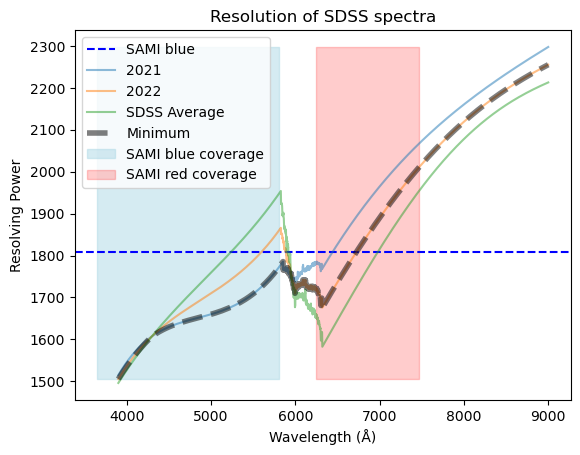

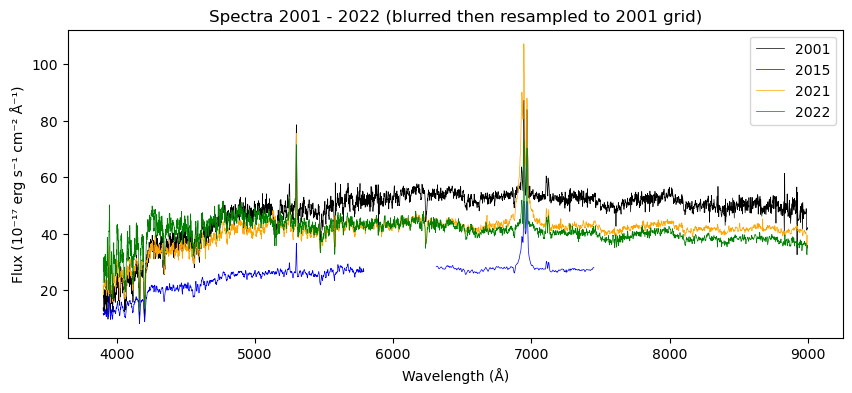

In [ ]:
data = get_data(plot_res_coverage=True) #TODO: compare 4 and 3 arcsec 
lam, (data01, data15, data21, data22) = data
flux01, err01 = data01
flux15, err15 = data15
flux21, err21 = data21
flux22, err22 = data22

#TODO: plot 4 and 3 arcsec 2015 side by side
# data_4arcsec = get_data(fname_2015_blue_4arcsec, fname_2015_red_4arcsec)
# data_3arcsec = get_data()


## Fitting a polynomial to ratio of different epochs to normalise

Qualitatively inspecting a sensible region of Balmer emission to ignore

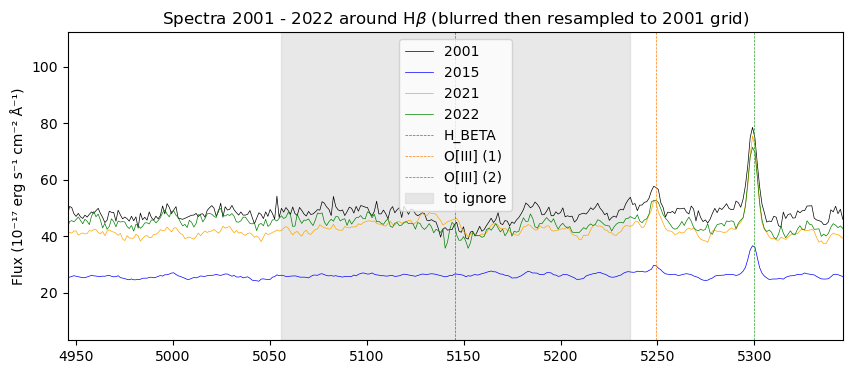

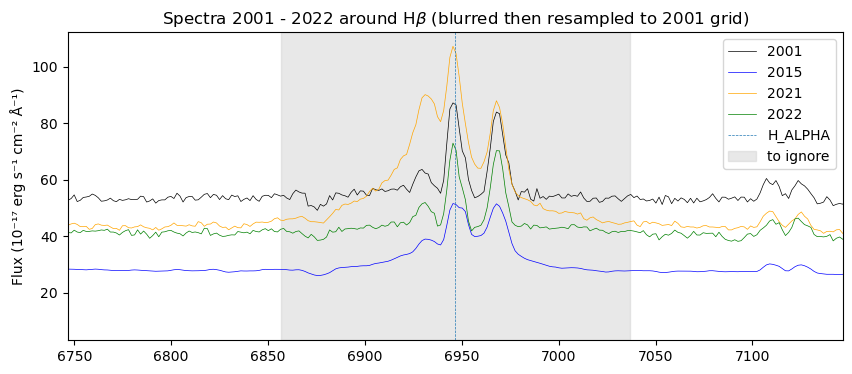

Width of wavelengths to ignore around Hα: 180 Å
Width of wavelengths to ignore around Hβ: 180 Å


In [ ]:
plt.figure(figsize=FIGURE_SIZE)
plt.plot(lam, flux01, color='black', label='2001', lw = LINEWIDTH)
plt.plot(lam, flux15, color='blue', label='2015', lw = LINEWIDTH)
plt.plot(lam, flux21, color='orange', label='2021', lw = LINEWIDTH)
plt.plot(lam, flux22, color='green', label='2022', lw = LINEWIDTH)
plot_vert_emission_lines(
    {"H_BETA": H_BETA, "O[III] (1)": OIII_1, "O[III] (2)": OIII_2}, get_lam_bounds(H_BETA, 400),
    fill_between_bounds=get_lam_bounds(H_BETA, LAMBDAS_TO_IGNORE_WIDTH),
    fill_between_label="to ignore"
)
plt.ylabel(SFD_Y_AX_LABEL)
plt.title(r"Spectra 2001 - 2022 around H$\beta$ (blurred then resampled to 2001 grid)")
plt.legend()
plt.show()

plt.figure(figsize=FIGURE_SIZE)
plt.plot(lam, flux01, color='black', label='2001', lw = LINEWIDTH)
plt.plot(lam, flux15, color='blue', label='2015', lw = LINEWIDTH)
plt.plot(lam, flux21, color='orange', label='2021', lw = LINEWIDTH)
plt.plot(lam, flux22, color='green', label='2022', lw = LINEWIDTH)
plot_vert_emission_lines(
    {"H_ALPHA": H_ALPHA}, get_lam_bounds(H_ALPHA, 400),
    fill_between_bounds=get_lam_bounds(H_ALPHA, LAMBDAS_TO_IGNORE_WIDTH),
    fill_between_label="to ignore"
)
plt.ylabel(SFD_Y_AX_LABEL)
plt.title(r"Spectra 2001 - 2022 around H$\beta$ (blurred then resampled to 2001 grid)")
plt.legend()
plt.show()
print(f"Width of wavelengths to ignore around Hα: {LAMBDAS_TO_IGNORE_WIDTH} Å")
print(f"Width of wavelengths to ignore around Hβ: {LAMBDAS_TO_IGNORE_WIDTH} Å")

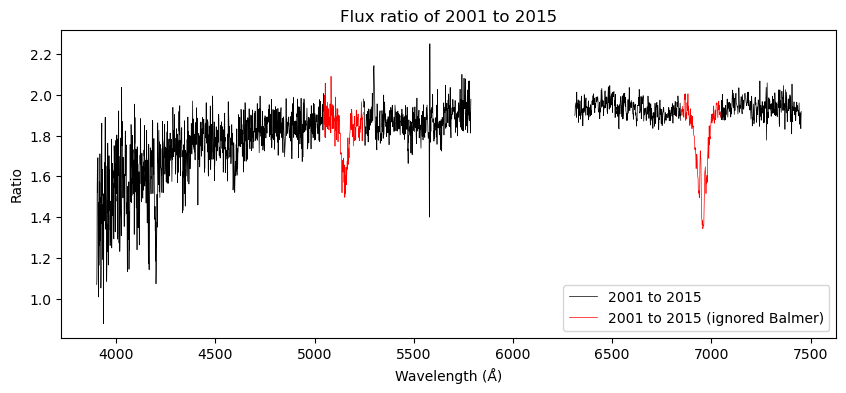

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)


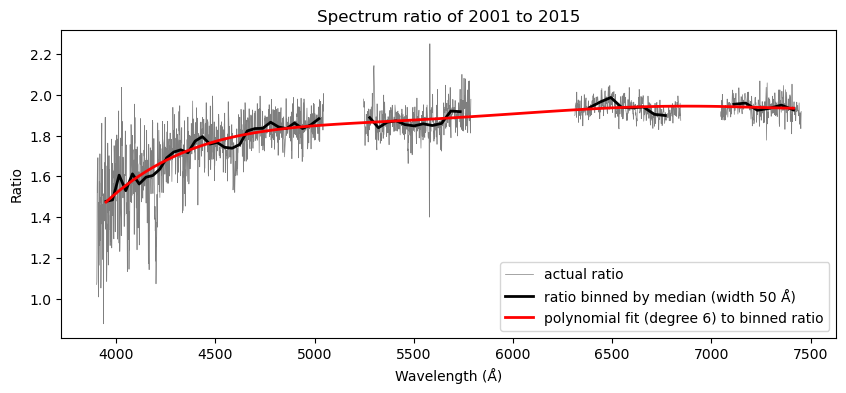

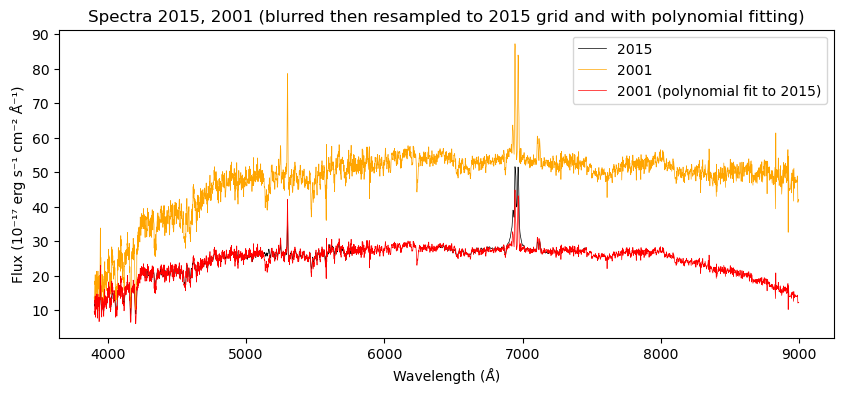

In [ ]:
#TODO: check if bin_width and poly_degree are ok
_, adjusted_01_flux_15, adjusted_01_err_15 = adjust_calibration(data=data, year_to_change="2001")
#
_, adjusted_21_flux_15, adjusted_21_err_15 = adjust_calibration(data=data, year_to_change="2021")
# same as adjusted_15_flux_15, adjusted_15_err_15 = flux15, err15
_, adjusted_15_flux_15, adjusted_15_err_15 = adjust_calibration(data=data, year_to_change="2015")
#
_, adjusted_22_flux_15, adjusted_22_err_15 = adjust_calibration(data=data, year_to_change="2022")

Sanity check on errors polynomial adjustment

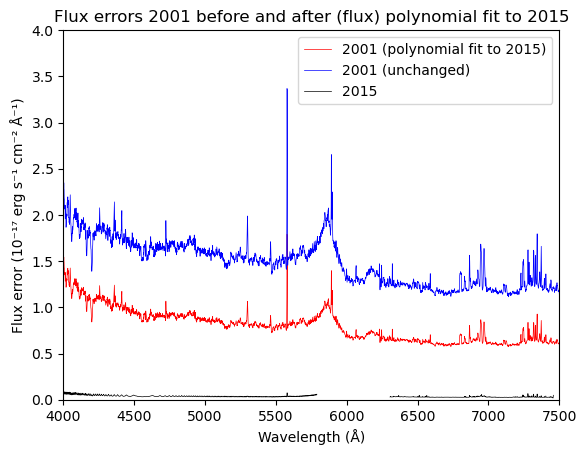

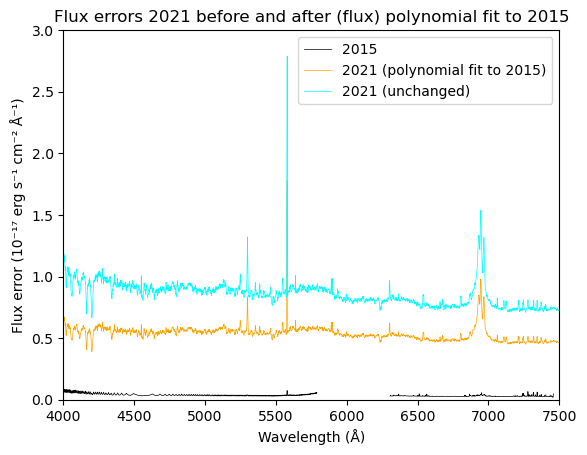

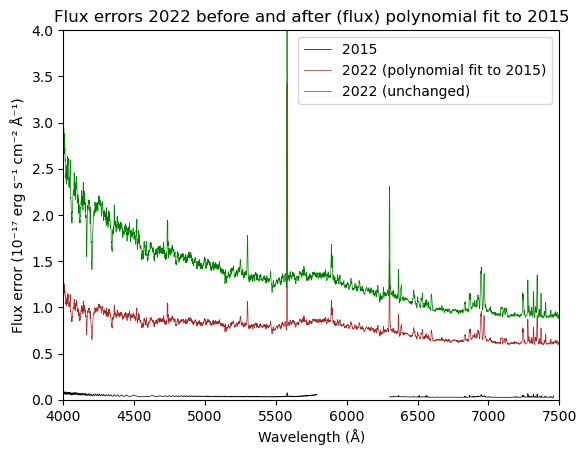

In [146]:
plt.plot(lam, adjusted_01_err_15, color='red', label='2001 (polynomial fit to 2015)', lw = LINEWIDTH)
plt.plot(lam, err01, color='blue', label='2001 (unchanged)', lw = LINEWIDTH)
# plt.plot(lam, adjusted_15_err_15, color='red', label='2015 (polynomial fit to 2015)', lw = LINEWIDTH)
plt.plot(lam, err15, color='black', label='2015', lw = LINEWIDTH)
plt.xlim(4000, 7500)
plt.ylim(0, 4)
plt.legend()
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux error (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title("Flux errors 2001 before and after (flux) polynomial fit to 2015")
plt.show()

plt.plot(lam, err15, color='black', label='2015', lw = LINEWIDTH)
plt.plot(lam, adjusted_21_err_15, color='orange', label='2021 (polynomial fit to 2015)', lw = LINEWIDTH)
plt.plot(lam, err21, color='cyan', label='2021 (unchanged)', lw = LINEWIDTH)
plt.xlim(4000, 7500)
plt.ylim(0, 3)
plt.legend()
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux error (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title("Flux errors 2021 before and after (flux) polynomial fit to 2015")
plt.show()

plt.plot(lam, err15, color='black', label='2015', lw = LINEWIDTH)
plt.plot(lam, adjusted_22_err_15, color='brown', label='2022 (polynomial fit to 2015)', lw = LINEWIDTH)
plt.plot(lam, err22, color='green', label='2022 (unchanged)', lw = LINEWIDTH)
plt.xlim(4000, 7500)
plt.ylim(0, 4)
plt.legend()
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux error (10⁻¹⁷ erg s⁻¹ cm⁻² Å⁻¹)")
plt.title("Flux errors 2022 before and after (flux) polynomial fit to 2015")
plt.show()

## Difference spectra

In [ ]:
def get_diff_spectra(
    adjusted_fluxes: tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray] | None = None,
    plot_spectrum: bool = True,
    plot_centre: float = H_ALPHA,
    years_to_plot: list[str] = ["2015", "2021", "2022"],
    ions: dict[str, float] | bool = True,
    plot_width: float | None = 400,
    plot_y_bounds: tuple[float, float] | bool = True,
    return_lam: bool = False
) -> tuple[
    tuple[np.ndarray, np.ndarray, np.ndarray],
    tuple[np.ndarray, np.ndarray, np.ndarray]
] | tuple[
    tuple[np.ndarray, np.ndarray, np.ndarray],
    tuple[np.ndarray, np.ndarray, np.ndarray],
    np.ndarray
]:
    if adjusted_fluxes is None:
        data = get_data(plot_resampled_and_blurred=False)
        lam = data[0]
        _, adjusted_01_flux_15, adjusted_01_err_15 = adjust_calibration(
            data=data, year_to_change="2001", 
            plot_ratio_selection=False, plot_poly_ratio=False, plot_adjusted=False,
        )
        _, adjusted_15_flux_15, adjusted_15_err_15 = adjust_calibration(
            data=data, year_to_change="2015",
            plot_ratio_selection=False, plot_poly_ratio=False, plot_adjusted=False,
        )
        _, adjusted_21_flux_15, adjusted_21_err_15 = adjust_calibration(
            data=data, year_to_change="2021",
            plot_ratio_selection=False, plot_poly_ratio=False, plot_adjusted=False,
        )
        _, adjusted_22_flux_15, adjusted_22_err_15 = adjust_calibration(
            data=data, year_to_change="2022",
            plot_ratio_selection=False, plot_poly_ratio=False, plot_adjusted=False,
        )
        # adjusted_fluxes = (adjusted_01_flux_15, adjusted_15_flux_15, adjusted_21_flux_15, adjusted_22_flux_15)
    else:
        (
            (adjusted_01_flux_15, adjusted_01_err_15),
            (adjusted_15_flux_15, adjusted_15_err_15),
            (adjusted_21_flux_15, adjusted_21_err_15),
            (adjusted_22_flux_15, adjusted_22_err_15)
        ) = adjusted_fluxes
        lam = None
    
    diff_15 = adjusted_15_flux_15 - adjusted_01_flux_15
    diff_21 = adjusted_21_flux_15 - adjusted_01_flux_15
    diff_22 = adjusted_22_flux_15 - adjusted_01_flux_15

    diff_15_err = np.sqrt(adjusted_01_err_15**2 + adjusted_15_err_15**2)
    diff_21_err = np.sqrt(adjusted_01_err_15**2 + adjusted_21_err_15**2)
    diff_22_err = np.sqrt(adjusted_01_err_15**2 + adjusted_22_err_15**2)

    if return_lam and lam is not None:
        to_return = (diff_15, diff_21, diff_22), (diff_15_err, diff_21_err, diff_22_err), lam
    elif return_lam and lam is None:
        raise ValueError(
            "lam can only be returned if adjusted_fluxes "
            "are calculated within this function."
        )
    else:
        to_return = (diff_15, diff_21, diff_22), (diff_15_err, diff_21_err, diff_22_err)
        
    if not plot_spectrum:
        return to_return
        

    plt.figure(figsize=FIGURE_SIZE)
    if "2015" in years_to_plot:
        plt.plot(lam, diff_15, alpha=0.7, color='black', label=f'2015 - 2001', lw = LINEWIDTH)
    if "2021" in years_to_plot:
        plt.plot(lam, diff_21, alpha=0.7, color='red', label=f'2021 - 2001', lw = LINEWIDTH)
    if "2022" in years_to_plot:
        plt.plot(lam, diff_22, alpha=0.7, color='blue', label=f'2022 - 2001', lw = LINEWIDTH)
        
    there_are_ions_to_plot = True
    if isinstance(ions, bool):
        if ions:
            if plot_centre == H_ALPHA:
                ions = {r"H-${\alpha}$": H_ALPHA, "S[II] (1)": SII_1, "S[II] (2)": SII_2, "N[II] (2)": NII_2}
            elif plot_centre == H_BETA:
                ions = {r"H-${\beta}$": H_BETA, "O[III] (1)": OIII_1, "O[III] (2)": OIII_2}
            else:
                there_are_ions_to_plot = False
        else:
            there_are_ions_to_plot = False

    x_bounds = get_lam_bounds(plot_centre, plot_width) if plot_width is not None else None

    if there_are_ions_to_plot:
        plot_vert_emission_lines(ions, x_bounds)
    elif x_bounds is not None:
        plt.xlim(x_bounds)

    if isinstance(plot_y_bounds, tuple):
        plt.ylim(plot_y_bounds[0], plot_y_bounds[1])
    elif plot_y_bounds:
        if plot_centre == H_ALPHA:
            plt.ylim(-10, 30)
        elif plot_centre == H_BETA:
            plt.ylim(-10, 20)

    plt.xlabel("Wavelength (Å)")
    plt.ylabel(SFD_Y_AX_LABEL)
    plt.title(f"Flux difference from 2001")
    plt.legend()
    plt.show()

    return to_return

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.pol

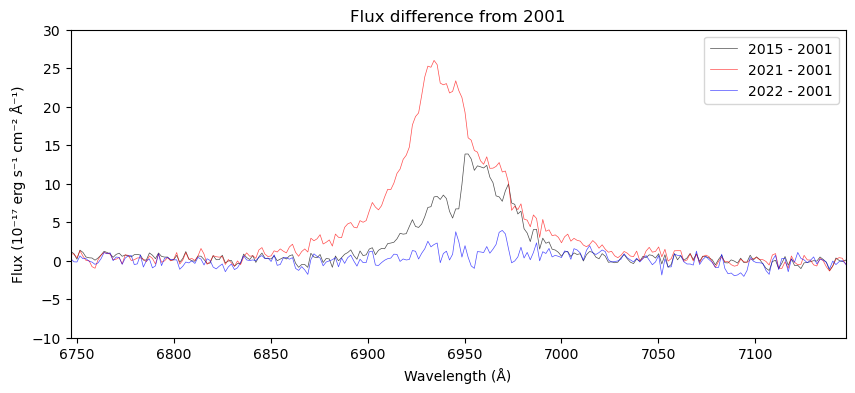

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)


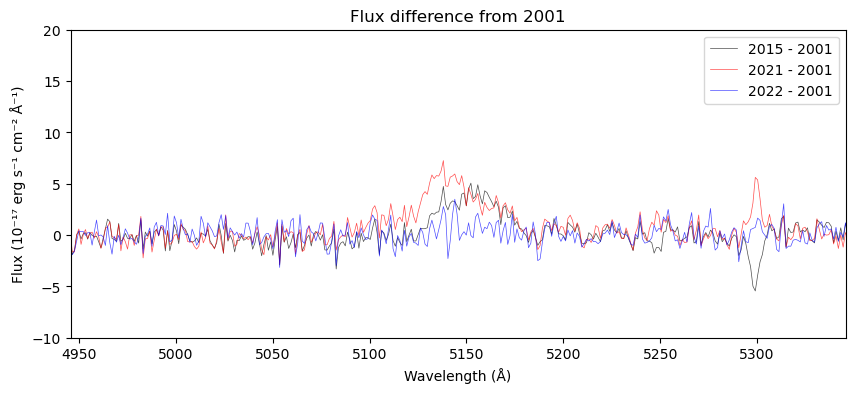

In [148]:
(diff_15, diff_21, diff_22), (diff_15_err, diff_21_err, diff_22_err) = get_diff_spectra(plot_spectrum=False)
get_diff_spectra(plot_centre=H_ALPHA, ions=False);
get_diff_spectra(plot_centre=H_BETA, ions=False);

In [149]:
def convert_lam_to_vel(
    lam: np.ndarray | float,
    lam_centre_rest_frame: float = H_ALPHA,
    lam_is_rest_frame: bool = False
) -> np.ndarray | float:
    # v = c * Δλ / λ_cent
    if lam_is_rest_frame:
        return (lam - lam_centre_rest_frame) * c_km_s / lam_centre_rest_frame
    else:
        return (lam / (1 + z) - lam_centre_rest_frame) * c_km_s / lam_centre_rest_frame

In [150]:
def convert_vel_to_lam(
    vel: np.ndarray | float,
    lam_centre_rest_frame: float = H_ALPHA,
    return_rest_frame: bool = False
) -> np.ndarray | float:
    # λ = λ_cent * (1 + v / c)
    if return_rest_frame:
        return lam_centre_rest_frame * (1 + vel / c_km_s)
    else:
        return (lam_centre_rest_frame * (1 + vel / c_km_s)) * (1 + z)

In [151]:
# def conv_lam_bounds_to_vel_bounds(
#     lam_centre_rest_frame: float,
#     lam_bounds_observed: tuple[float, float]
# ) -> tuple[float, float]:
#     lam_bounds_rest_frame = lam_bounds_observed / (1 + z)

#     delta_lam_left = lam_bounds_rest_frame[0] - lam_centre_rest_frame
#     delta_lam_right = lam_bounds_rest_frame[1] - lam_centre_rest_frame

#     vel_left = delta_lam_left * c / lam_centre_rest_frame
#     vel_right = delta_lam_right * c / lam_centre_rest_frame
#     return (vel_left, vel_right)

In [ ]:
def integrate_flux(
    lam: np.ndarray,
    flux_diff: np.ndarray,
    sigma_diff: np.ndarray,
    lam_bounds: tuple[float, float],
    use_mult_gaussians: bool = False,
    n_gaussians: int = 1
) -> tuple[float, float]:
    valid_mask = np.where((lam > lam_bounds[0]) & (lam < lam_bounds[1]))
    lam_portion = lam[valid_mask]
    flux_portion = flux_diff[valid_mask]
    sig_portion = sigma_diff[valid_mask]
    
    if use_mult_gaussians:
        #TODO: add stuff here
        pass
    else:
        #TODO: manually do trapezoidal rule so that errors can be calculated
            # see test_workspace.py
        flux = simpson(flux_portion, x=lam_portion)
        flux_err = None
        #

    return flux, flux_err

In [ ]:
def convert_flux_to_mJy(
    flux: float,
    col_band_eff_width: float,
    col_band_eff_lam: float
) -> float:
    """
    Convert integrated line flux to equivalent broadband flux density in mJy.
    
    Parameters:
    -----------
    flux : float
        Integrated line flux in units of 10^-17 erg s^-1 cm^-2
        (i.e., the numerical value from integrate_flux)
    col_band_eff_width : float
        Effective width of the photometric band in Angstroms
    col_band_eff_lam : float
        Effective central wavelength of the photometric band in Angstroms
    
    Returns:
    --------
    float
        Flux density in mJy
    
    Notes:
    ------
    The conversion assumes the line flux is spread uniformly over the
    frequency width corresponding to the photometric band.
    """
    
    # Calculate frequency width in Hz
    # Using c_ang_s (speed of light in Å/s) for consistent units
    freq_eff_width = c_ang_s * col_band_eff_width / (col_band_eff_lam**2)  # Hz
    
    # Calculate flux density
    flux_density = flux / freq_eff_width  # erg s^-1 cm^-2 Hz^-1
    
    # Convert to mJy 
    # 1 Jy = 10^-23 erg s^-1 cm^-2 Hz^-1
    # 10^-17 erg s^-1 cm^-2 = 10^9 mJy
    flux_density_mjy = flux_density * 1e9
    
    return flux_density_mjy



In [ ]:
def calculate_balmer_decrement(
    lam: np.ndarray,
    flux_diff: np.ndarray,
    sigma_diff: np.ndarray,
    vel_width: float,
    num_bins: int | None = 6,
    bin_width: float | None = None,
    modify_vel_width: bool = False
) -> tuple[np.ndarray, np.ndarray, np.ndarray] | tuple[float, float]:
    if num_bins is None:
        if bin_width is None:
            raise ValueError("Either num_bins or bin_width must be provided")
        if modify_vel_width:
            vel_width -= vel_width % bin_width
            print(
                f"vel_width is not a factor of bin_width, "
                f"so it has been modified to {vel_width}"
            )
        else:
            raise ValueError("bin_width is not a factor of vel_width")
        num_bins = vel_width // bin_width
    elif bin_width is None:
        bin_width = vel_width / num_bins
    else:
        raise ValueError("Only one of num_bins or bin_width must be provided")

    
    if num_bins == 1:
        h_alpha_lam_bounds = (convert_vel_to_lam(-vel_width, H_ALPHA), convert_vel_to_lam(vel_width, H_ALPHA))
        h_beta_lam_bounds = (convert_vel_to_lam(-vel_width, H_BETA), convert_vel_to_lam(vel_width, H_BETA))

        h_alpha_flux, h_alpha_flux_err = integrate_flux(lam, flux_diff, sigma_diff, h_alpha_lam_bounds)
        h_beta_flux, h_beta_flux_err = integrate_flux(lam, flux_diff, sigma_diff, h_beta_lam_bounds)
        #TODO: calculate errors
        balmer_decrement_err = None
        #
        return h_alpha_flux / h_beta_flux, balmer_decrement_err

    balmer_decrements = []
    balmer_decrements_err = []
    vel_bin_centres = []
    add_info = []

    for i in range(num_bins):
        vel_left = -vel_width / 2 + i * bin_width
        vel_centre = vel_left + bin_width / 2
        vel_right = vel_left + bin_width

        cur_lam_bounds_alpha = (convert_vel_to_lam(vel_left, H_ALPHA), convert_vel_to_lam(vel_right, H_ALPHA))
        cur_lam_bounds_beta = (convert_vel_to_lam(vel_left, H_BETA), convert_vel_to_lam(vel_right, H_BETA))

        h_alpha_flux, h_alpha_flux_err = integrate_flux(lam, flux_diff, sigma_diff, cur_lam_bounds_alpha)
        h_beta_flux, h_beta_flux_err = integrate_flux(lam, flux_diff, sigma_diff, cur_lam_bounds_beta)

        balmer_decrements.append(h_alpha_flux / h_beta_flux)
        vel_bin_centres.append(vel_centre)
        #TODO: remove testing
        add_info.append((vel_left, vel_centre, vel_right))
        balmer_decrement_err = None
        #
        
        #TODO: check this is correct
        # balmer_decrement_err = (h_alpha_flux / h_beta_flux) * (h_alpha_flux_err / h_alpha_flux + h_beta_flux_err / h_beta_flux)

        balmer_decrements_err.append(balmer_decrement_err)
    
    return np.array(balmer_decrements), np.array(balmer_decrements_err), np.array(vel_bin_centres)

In [230]:
integrated_flux_15_alpha, integrated_flux_15_alpha_err = integrate_flux(lam, diff_15, diff_15_err, get_lam_bounds(H_ALPHA, LAMBDAS_TO_IGNORE_WIDTH))
integrated_flux_21_alpha, integrated_flux_21_alpha_err = integrate_flux(lam, diff_21, diff_21_err, get_lam_bounds(H_ALPHA, LAMBDAS_TO_IGNORE_WIDTH))
integrated_flux_22_alpha, integrated_flux_22_alpha_err = integrate_flux(lam, diff_22, diff_22_err, get_lam_bounds(H_ALPHA, LAMBDAS_TO_IGNORE_WIDTH))

integrated_flux_15_beta, integrated_flux_15_beta_err = integrate_flux(lam, diff_15, diff_15_err, get_lam_bounds(H_BETA, LAMBDAS_TO_IGNORE_WIDTH))
integrated_flux_21_beta, integrated_flux_21_beta_err = integrate_flux(lam, diff_21, diff_21_err, get_lam_bounds(H_BETA, LAMBDAS_TO_IGNORE_WIDTH))
integrated_flux_22_beta, integrated_flux_22_beta_err = integrate_flux(lam, diff_22, diff_22_err, get_lam_bounds(H_BETA, LAMBDAS_TO_IGNORE_WIDTH))

h_alpha_flux_21_atlas_mJy = convert_flux_to_mJy(integrated_flux_21_alpha, ATLAS_O_BAND_WIDTH, ATLAS_O_BAND_LAM)
h_alpha_flux_21_ztf_mJy = convert_flux_to_mJy(integrated_flux_21_alpha, ZTF_I_BAND_WIDTH, ZTF_I_BAND_LAM)
h_alpha_flux_21_assasn_mJy = convert_flux_to_mJy(integrated_flux_21_alpha, ASSASN_V_BAND_WIDTH, ASSASN_V_BAND_LAM)
h_beta_flux_21_assasn_mJy = convert_flux_to_mJy(integrated_flux_21_beta, ASSASN_G_BAND_WIDTH, ASSASN_G_BAND_LAM)

h_alpha_flux_22_atlas_mJy = convert_flux_to_mJy(integrated_flux_22_alpha, ATLAS_O_BAND_WIDTH, ATLAS_O_BAND_LAM)
h_alpha_flux_22_ztf_mJy = convert_flux_to_mJy(integrated_flux_22_alpha, ZTF_I_BAND_WIDTH, ZTF_I_BAND_LAM)
h_alpha_flux_22_assasn_mJy = convert_flux_to_mJy(integrated_flux_22_alpha, ASSASN_V_BAND_WIDTH, ASSASN_V_BAND_LAM)
h_beta_flux_22_assasn_mJy = convert_flux_to_mJy(integrated_flux_22_beta, ASSASN_G_BAND_WIDTH, ASSASN_G_BAND_LAM)

print(f"Hα flux 2015 - 2001: {integrated_flux_15_alpha:.2f} erg s⁻¹ cm⁻²")
print(f"Hα flux 2021 - 2001: {integrated_flux_21_alpha:.2f} erg s⁻¹ cm⁻²")
print(f"Hα flux 2022 - 2001: {integrated_flux_22_alpha:.2f} erg s⁻¹ cm⁻²")
print()
print(f"Hβ flux 2015 - 2001: {integrated_flux_15_beta:.2f} erg s⁻¹ cm⁻²")
print(f"Hβ flux 2021 - 2001: {integrated_flux_21_beta:.2f} erg s⁻¹ cm⁻²")
print(f"Hβ flux 2022 - 2001: {integrated_flux_22_beta:.2f} erg s⁻¹ cm⁻²")
print()
print(f"Hα flux 2021 - 2001 (as if it were recorded in the ATLAS o band): {h_alpha_flux_21_atlas_mJy:.2e} mJy")
print(f"Hα flux 2021 - 2001 (as if it were recorded in the ZTF i band): {h_alpha_flux_21_ztf_mJy:.2e} mJy")
print(f"Hα flux 2021 - 2001 (as if it were recorded in the ASSASN V band): {h_alpha_flux_21_assasn_mJy:.2e} mJy")
print(f"Hβ flux 2021 - 2001 (as if it were recorded in the ASSASN G band): {h_beta_flux_21_assasn_mJy:.2e} mJy")
print()
print(f"Hα flux 2022 - 2001 (as if it were recorded in the ATLAS o band): {h_alpha_flux_22_atlas_mJy:.2e} mJy")
print(f"Hα flux 2022 - 2001 (as if it were recorded in the ZTF i band): {h_alpha_flux_22_ztf_mJy:.2e} mJy")
print(f"Hα flux 2022 - 2001 (as if it were recorded in the ASSASN V band): {h_alpha_flux_22_assasn_mJy:.2e} mJy")
print(f"Hβ flux 2022 - 2001 (as if it were recorded in the ASSASN G band): {h_beta_flux_22_assasn_mJy:.2e} mJy")

Hα flux 2015 - 2001: 630.86 erg s⁻¹ cm⁻²
Hα flux 2021 - 2001: 1470.80 erg s⁻¹ cm⁻²
Hα flux 2022 - 2001: 122.58 erg s⁻¹ cm⁻²

Hβ flux 2015 - 2001: 121.61 erg s⁻¹ cm⁻²
Hβ flux 2021 - 2001: 273.16 erg s⁻¹ cm⁻²
Hβ flux 2022 - 2001: 19.04 erg s⁻¹ cm⁻²

Hα flux 2021 - 2001 (as if it were recorded in the ATLAS o band): 8.05e-03 mJy
Hα flux 2021 - 2001 (as if it were recorded in the ZTF i band): 2.51e-02 mJy
Hα flux 2021 - 2001 (as if it were recorded in the ASSASN V band): 9.89e-03 mJy
Hβ flux 2021 - 2001 (as if it were recorded in the ASSASN G band): 1.34e-03 mJy

Hα flux 2022 - 2001 (as if it were recorded in the ATLAS o band): 6.71e-04 mJy
Hα flux 2022 - 2001 (as if it were recorded in the ZTF i band): 2.09e-03 mJy
Hα flux 2022 - 2001 (as if it were recorded in the ASSASN V band): 8.25e-04 mJy
Hβ flux 2022 - 2001 (as if it were recorded in the ASSASN G band): 9.35e-05 mJy


In [156]:
balmer_dec_15, balmer_dec_15_err = calculate_balmer_decrement(
    lam, diff_15, diff_15_err,
    BALMER_DECREMENT_VEL_WIDTH, num_bins=1
)
balmer_dec_21, balmer_dec_21_err = calculate_balmer_decrement(
    lam, diff_21, diff_21_err,
    BALMER_DECREMENT_VEL_WIDTH, num_bins=1
)
balmer_dec_22, balmer_dec_22_err = calculate_balmer_decrement(
    lam, diff_22, diff_22_err,
    BALMER_DECREMENT_VEL_WIDTH, num_bins=1
)

print(f"Balmer decrement 2015 - 2001: {balmer_dec_15:.2f} ± {balmer_dec_15_err}")
print(f"Balmer decrement 2021 - 2001: {balmer_dec_21:.2f} ± {balmer_dec_21_err}")
print(f"Balmer decrement 2022 - 2001: {balmer_dec_22:.2f} ± {balmer_dec_22_err}")

Balmer decrement 2015 - 2001: 4.65 ± None
Balmer decrement 2021 - 2001: 5.42 ± None
Balmer decrement 2022 - 2001: 6.18 ± None


In [219]:
def plot_balmer_decrement(
    diff_year: str | None = "2021",
    lam: np.ndarray | None = None,
    diff_flux: np.ndarray | None = None,
    diff_flux_err: np.ndarray | None = None,
    plot_vel_width: float | None = 7000,
    balm_dec_vel_width: float | None = BALMER_DECREMENT_VEL_WIDTH,
    num_bins: int | None = 6,
    bin_width: float | None = None,
    modify_vel_width: bool = False
) -> tuple[np.ndarray, np.ndarray]:
    if diff_year is None:
        if diff_flux is None or diff_flux_err is None:
            raise ValueError(
                "diff_flux and diff_flux_err must be "
                "provided if diff_year is not provided"
            )
    else:
        if diff_flux is not None or diff_flux_err is not None:
            raise ValueError(
                "diff_flux and diff_flux_err must not be "
                "provided if diff_year is provided"
            )
        
        all_diff_fluxes, all_diff_flux_errs, lam = get_diff_spectra(
            plot_spectrum=False, return_lam=True
        )
        if diff_year == "2015":
            diff_flux = all_diff_fluxes[0]
            diff_flux_err = all_diff_flux_errs[0]
        elif diff_year == "2021":
            diff_flux = all_diff_fluxes[1]
            diff_flux_err = all_diff_flux_errs[1]
        elif diff_year == "2022":
            diff_flux = all_diff_fluxes[2]
            diff_flux_err = all_diff_flux_errs[2]
        else:
            raise ValueError("Invalid year")
        
    balmer_dec, balmer_dec_err, vel_bin_centres = calculate_balmer_decrement(
        lam, diff_flux, diff_flux_err,
        balm_dec_vel_width, num_bins=num_bins,
        bin_width=bin_width, modify_vel_width=modify_vel_width
    )
        
    balmer_dec_1_bin, balmer_dec_err_1_bin = calculate_balmer_decrement(
        lam, diff_flux, diff_flux_err,
        balm_dec_vel_width, num_bins=1
    )

    # AI code below

    # Set default values if not provided
    if plot_vel_width is None:
        plot_vel_width = balm_dec_vel_width
    
    # Calculate bin width from parameters
    if bin_width is None:
        actual_bin_width = balm_dec_vel_width / num_bins
    else:
        actual_bin_width = bin_width
    
    # Extract H_alpha region and convert to velocity space
    h_alpha_lam_bounds = (
        convert_vel_to_lam(-plot_vel_width / 2, H_ALPHA),
        convert_vel_to_lam(plot_vel_width / 2, H_ALPHA)
    )
    h_alpha_mask = (lam >= h_alpha_lam_bounds[0]) & (lam <= h_alpha_lam_bounds[1])
    h_alpha_lam = lam[h_alpha_mask]
    h_alpha_flux = diff_flux[h_alpha_mask]
    h_alpha_vel = convert_lam_to_vel(h_alpha_lam, H_ALPHA)
    
    # Extract H_beta region and convert to velocity space
    h_beta_lam_bounds = (
        convert_vel_to_lam(-plot_vel_width / 2, H_BETA),
        convert_vel_to_lam(plot_vel_width / 2, H_BETA)
    )
    h_beta_mask = (lam >= h_beta_lam_bounds[0]) & (lam <= h_beta_lam_bounds[1])
    h_beta_lam = lam[h_beta_mask]
    h_beta_flux = diff_flux[h_beta_mask]
    h_beta_vel = convert_lam_to_vel(h_beta_lam, H_BETA)
    
    # Create figure with primary axis
    fig, ax1 = plt.subplots(figsize=FIGURE_SIZE)
    
    # Plot H_alpha and H_beta diff_flux in velocity space
    ax1.plot(h_alpha_vel, h_alpha_flux, color='red', lw=LINEWIDTH, label=r'H$\alpha$')
    ax1.plot(h_beta_vel, h_beta_flux, color='blue', lw=LINEWIDTH, label=r'H$\beta$')
    
    # Interpolate H_beta onto H_alpha's velocity grid to compute flux ratio
    h_beta_flux_interp = np.interp(h_alpha_vel, h_beta_vel, h_beta_flux)
    flux_ratio = h_alpha_flux / h_beta_flux_interp

    ax1.axhline(0, color='gray', linestyle='--', lw=0.5, alpha=0.7)
    ax1.set_xlabel('Velocity (km/s)')
    ax1.set_ylabel(SFD_Y_AX_LABEL)
    ax1.legend(loc='upper left')
    ax1.set_xlim(-plot_vel_width / 2, plot_vel_width / 2)
    
    # Create secondary y-axis for Balmer decrement
    ax2 = ax1.twinx()
    
    # Plot H_alpha / H_beta flux ratio in velocity space
    ax2.plot(h_alpha_vel, flux_ratio, color='green', lw=LINEWIDTH, alpha=0.7, 
             label=r'H$\alpha$/H$\beta$ ratio')
    
    # Plot Balmer decrement as horizontal lines with dots at centre
    for vel_centre, bd in zip(vel_bin_centres, balmer_dec):
        vel_left = vel_centre - actual_bin_width / 2
        vel_right = vel_centre + actual_bin_width / 2
        ax2.plot([vel_left, vel_right], [bd, bd], color='black', lw=1.5)
        ax2.plot(vel_centre, bd, 'o', color='black', markersize=5)
    ax2.plot([np.nan], [np.nan], 'o', color='black', markersize=5, label="Balmer decrement\n(integrated flux\nin velocity bins)")
    ax2.axhline(balmer_dec_1_bin, color='blue', linestyle='--', lw=1.5, label=f"Balmer decrement =\n{balmer_dec_1_bin:.2f} (no binning)")
    
    ax2.set_ylabel(r'Balmer Decrement (H$\alpha$ / H$\beta$)')
    ax2.legend(loc='upper right')
    
    # Scale axes so 0 points align
    # Get flux axis limits
    flux_min, flux_max = ax1.get_ylim()
    flux_range = flux_max - flux_min
    
    # Get balmer decrement range with padding (only based on binned values)
    bd_min = np.min(balmer_dec)
    bd_max = np.max(balmer_dec)
    bd_range = bd_max - bd_min
    bd_padding = bd_range * 0.3 if bd_range > 0 else 0.5
    bd_min_padded = bd_min - bd_padding
    bd_max_padded = bd_max + bd_padding
    
    # Calculate the position of 0 as a fraction of the flux axis (from bottom)
    # zero_pos = (0 - flux_min) / flux_range
    zero_pos = -flux_min / flux_range
    
    # Set Balmer decrement axis limits so 0 is at the same fractional position
    # bd_axis_min + zero_pos * bd_axis_range = 0
    # => bd_axis_min = -zero_pos * bd_axis_range
    # Also: bd_axis_max = bd_axis_min + bd_axis_range
    # We want the BD data to fit, so calculate the needed range
    bd_data_range = bd_max_padded - bd_min_padded
    
    # The BD data should fit in the visible portion above 0
    # If zero_pos is small (0 near bottom), most of axis is for positive values
    if zero_pos > 0.01 and zero_pos < 0.99:
        # Calculate axis range needed to fit BD data above 0
        # The portion above 0 is (1 - zero_pos) of the total axis range
        bd_axis_range = bd_max_padded / (1 - zero_pos)
        bd_axis_min = -zero_pos * bd_axis_range
        bd_axis_max = bd_axis_min + bd_axis_range
        ax2.set_ylim(bd_axis_min, bd_axis_max)
    else:
        # Just show the BD data with padding
        ax2.set_ylim(bd_min_padded, bd_max_padded)
    
    # Add horizontal line at 0 on secondary axis (should now align with flux 0)
    ax2.axhline(0, color='gray', linestyle='--', lw=0.5, alpha=0.7)

    plt.axvline(balm_dec_vel_width/2, color='gray', linestyle='--', lw=2, alpha=0.7)
    plt.axvline(-balm_dec_vel_width/2, color='gray', linestyle='--', lw=2, alpha=0.7)
    
    # Add title
    if diff_year is not None:
        title = f'Balmer Decrement - {diff_year}'
    else:
        title = 'Balmer Decrement'
    ax1.set_title(title)
    
    plt.tight_layout()
    plt.show()
    
    return balmer_dec, balmer_dec_err

/opt/anaconda3/envs/denison/lib/python3.11/site-packages/spectres/spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)


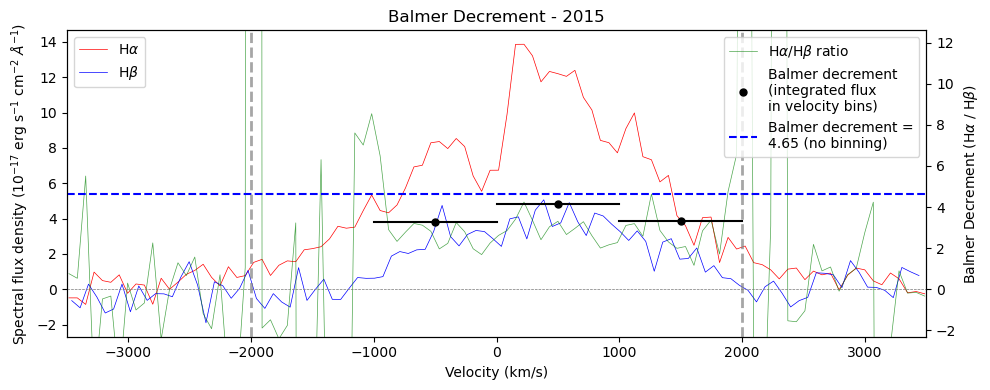

In [220]:
plot_balmer_decrement(diff_year="2015", num_bins=4);

/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)
/var/folders/2c/yg0cprnj3nx6rr3zg229jc7h0000gn/T/ipykernel_3935/3384583238.py:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(new_lambdas[valid_mask], new_vals[valid_mask], degree)


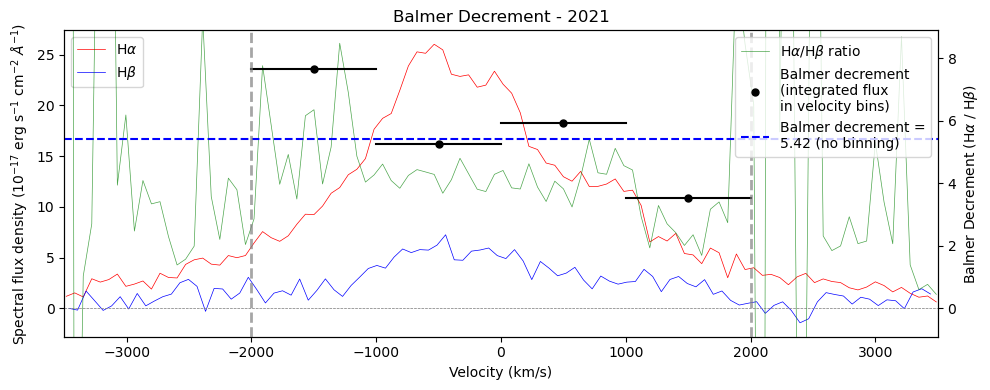

In [221]:
plot_balmer_decrement(diff_year="2021", num_bins=4);

## Gaussian fit

In [ ]:
# limiting range to close to the H alpha line
idx = np.where((lam01 > 6700) & (lam01 < 7200))
x = lam01[idx]
y = diff_15_01[idx]
sig = sigma_diff[idx]
sig[sig == 0] = np.min(sig[sig > 0]) ## dealing with division by 0

# Compute weights for the fitting
weights = 1.0 / sig

# establishing initial guesses for the fit
peaks, properties = find_peaks(y, height=np.std(y)*3, distance=3)  # tweak height/distance
peaks = peaks[:2]       ## change this depending on how many peaks you want captured
mu_guesses = x[peaks]
amp_guesses = properties["peak_heights"]
results_half = peak_widths(y, peaks, rel_height=0.5)
sigma_guesses = results_half[0] * (x[1] - x[0]) / (2*np.sqrt(2*np.log(2)))  # convert FWHM → stddev


# perform the fit:
model = None
params = None

for i, (amp, mu, sigma) in enumerate(zip(amp_guesses, mu_guesses, sigma_guesses)):
    prefix = f"g{i}_"
    g = GaussianModel(prefix=prefix)
    if model is None:
        model = g
        params = g.make_params()
    else:
        model += g
        params.update(g.make_params())
    
    # set parameter guesses
    params[prefix+'amplitude'].set(value=amp*np.sqrt(2*np.pi)*sigma, min=0)
    params[prefix+'center'].set(value=mu)
    params[prefix+'sigma'].set(value=sigma, min=0.1)


result = model.fit(y, params, x=x, weights=weights)
#print(result.fit_report()) #uncomment if you want the fit report!


# Plot the outcome!
redchisq = result.redchi    # lmfit stores reduced chisq here
plt.figure(figsize=(10,6))
plt.plot(x, y, label="Data", alpha=0.6)
plt.plot(x, result.best_fit, 'r-', label="Total fit", lw=2)

# Plot each component separately
for name, comp in result.eval_components(x=x).items():
    plt.plot(x, comp, '--', label=name)

# Plot uncertainty band (gray stripe)
plt.fill_between(
    x,
    y - sig,
    y + sig,
    color="gray",
    alpha=0.3,
    label="Uncertainty"
)
plt.ylabel(SFD_Y_AX_LABEL)
plt.xlabel("Wavelength (Å)")
plt.title("Multi-Gaussian Fit Hα 2021 Difference Spectrum")
    
plt.text(
    0.05, 0.95,         
    f"Reduced χ² = {result.redchi:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)
plt.legend()
plt.show()

: 

## Extracting fit parameters with monte carlo sampling
for the full width at half maximum and the luminosity (from integrated flux)

note: if you only fit one gaussian, you can find the fwhm + uncertainty in the fit report

In [ ]:
def fwhm_from_fit(x, y, sig, model, params, n_trials):
    # n_trials = no. of monte carlo samples
  fwhm_list = []
  weights = 1.0 / sig
  for _ in range(n_trials):
    y_perturbed = y + np.random.normal(0, sig) # perturb the data with noise from uncertainty arr

    result_mc = model.fit(y_perturbed, params.copy(), x=x, weights=weights) # refit model

    #compute fwhm
    y_fit_mc = result_mc.best_fit
    half_max = np.max(y_fit_mc) / 2
    above_half = np.where(y_fit_mc >= half_max)[0]
    if len(above_half) > 1:
      fwhm = x[above_half[-1]] - x[above_half[0]]
      fwhm_list.append(fwhm)

  # extract values
  fwhm_mean = np.mean(fwhm_list) * u.AA
  fwhm_std = np.std(fwhm_list) * u.AA

  # convert to km/s
  rest_wavelength = 6562.8 * u.AA  # Hα rest wavelength
  fwhm_vel = (fwhm_mean / rest_wavelength) * c.to(u.km/u.s)
  fwhm_vel_err = (fwhm_std / rest_wavelength)* c.to(u.km/u.s)

  return fwhm_vel, fwhm_vel_err


In [ ]:
def lum_from_fit(x, y, sig, model, params, n_trials):
  trapflux_list = []
  weights = 1.0 / sig
  for _ in range(n_trials):
      y_perturbed = y + np.random.normal(0, sig) # perturb the data with noise from uncertainty arr

      result_mc = model.fit(y_perturbed, params.copy(), x=x, weights=weights) #refit model

      y_fit_mc = result_mc.best_fit
      trapflux = np.trapz(y_fit_mc, x)  #integrate with trapezoidal rule
      trapflux_list.append(trapflux)

  # extract values: mean and sd of the sampled integrals
  trap_mean = np.mean(trapflux_list) * (10**(-17)) * u.erg / (u.s * u.cm**2)
  trap_std = np.std(trapflux_list) * (10**(-17)) * u.erg / (u.s * u.cm**2)
  
  # Luminosity distance
  z = 0.0582
  d = cosmo.luminosity_distance(z)
  d = d.to(u.cm)

  # compute luminosity
  luminosity = trap_mean * 4 * np.pi * (d**2)
  lum_err = trap_std * 4 * np.pi * (d**2)

  return luminosity, lum_err


Note: this will take a while to run! lower the number of samples to test

In [ ]:
fwhm_velocity_ha, fwhm_vel_err_ha = fwhm_from_fit(x, y, sig, model, params, 500)
luminosity_ha, lum_err_ha = lum_from_fit(x, y, sig, model, params, 500)

In [ ]:
print(f"fwhm: {fwhm_velocity_ha:.2e} ± {fwhm_vel_err_ha:.2e} ")
print(f"luminosity: {luminosity_ha:.2e} ± {lum_err_ha:.2e} ")

### Then to find BH mass!

In [ ]:
def bh_mass(l_ha, l_ha_err, fwhm_ha, fwhm_ha_err):
    """
    Estimate BH mass from Halpha line. Using the equation from Greene & Ho 2005
    
    Parameters:
    l_ha : Halpha luminosity in erg/s (with error l_ha_err)
    fwhm_ha : Halpha line FWHM in km/s (with error fwhm_ha_err)

    Returns:
    mbh : Black hole mass in solar masses (with error mbh_err)
    Note: mbh_err calculated using log(mass) for easier calculation
    """
    coeff = 2.0e6  
    exp_l = 0.55
    exp_fwhm = 2.06

    # Normalize inputs
    l_norm = l_ha / 1e42
    fwhm_norm = fwhm_ha / 1e3 
    mbh = coeff * (l_norm**exp_l) * (fwhm_norm**exp_fwhm)

    # uncertainty (using log(mass))
    sig_loglum = (1/np.log(10)) * (l_ha_err / l_ha)
    sig_logfwhm = (1/np.log(10)) * (fwhm_ha_err / fwhm_ha)
    sig_loga = (1/np.log(10)) * (0.35 / 2)
    sig_b = 0.02
    sig_c = 0.06
    b = 0.55
    c = 2.06

    
    var_logm = (sig_loga)**2 + (np.log10(l_ha/(10**42)) * sig_b)**2 + (b*sig_loglum)**2 + (np.log10(fwhm_ha/(10**3)) * sig_c)**2 + (c*sig_logfwhm)**2

    sig_logm = np.sqrt(var_logm)
    mbh_err = np.log(10) * mbh * sig_logm

    return mbh, mbh_err


mass, sig_m = bh_mass(luminosity_ha.value, lum_err_ha.value, fwhm_velocity_ha.value, fwhm_vel_err_ha.value)
print(f"Estimated black hole mass: {mass:.2e} ± {sig_m:.2e} M_sun")

## D4000 functions

From Scott Croom

In [ ]:
#Conversion from FWHM to Gaussian sigma
FWHM_sigma=2.0*np.sqrt(2.0*np.log(2.0))

##A Gaussian function
#x=independenat variable
#a=amplitude
#b=phase shift (left or right)
#c=sigma
#d=zero-point offset (up or down)
def gaussian(x,a,b,c,d):
    return a*np.exp(-(x-b)**2/(2*c**2))+d

## Convert fluxes per Angstrom to fluxes per pixel
#wave=Wavelength vector
#spec=spectrum in units of flux per angstrom
def flux_per_pix(wave,spec):
    d_lam=[]
    for i in range(1,len(wave)):
        d_lam.append(wave[i]-wave[i-1])
    d_lam.append(d_lam[-1])
    d_lam=np.array(d_lam)
    return spec*d_lam

#resolution at which to calculate indices. 
#These values should be sigmas in Angstroms
lick_res={'D4000': 11.0/FWHM_sigma,   #This may not be the right resolution. Was 16 A FWHM in Balogh et al. 1999, but smoothing may not have been applied in subsequent papers. Ask Nic Scott!
          'Hdelta_A': 10.0/FWHM_sigma,
          'Ca4227': 9.0/FWHM_sigma,
          'G4300': 9.5/FWHM_sigma,
          'Fe4383': 9.0/FWHM_sigma,
          'Fe5270': 8.4/FWHM_sigma,
          'Hbeta':8.4/FWHM_sigma,
          'Mg_b': 8.4/FWHM_sigma,
          'CN_1': 10.0/FWHM_sigma,
          'CN_2': 10.0/FWHM_sigma        
}

#Index passbands in order of increasing wavelength
lick_window={'D4000_1':[3850.0,3950.0],  #Index invented by Balogh et al. 1999
             'D4000_2':[4000.0,4100.0],  #Index invented by Balogh et al. 1999
             'Mg_b_1':[4041.60,4079.75],  #Worthey & Ottaviani 1997
             'Mg_b_2':[4083.50,4122.25],
             'Mg_b_3':[4128.50,4161.00],
             'Ca4227_1':[4211.000,4219.750], #Lick system
             'Ca4227_2':[4222.250,4234.750],
             'Ca4227_3':[4241.000,4251.000],
             'G4300_1':[4266.375,4282.625], #Lick system
             'G4300_2':[4281.375,4316.375],
             'G4300_3':[4318.875,4335.125],
             'Fe4383_1':[4359.125,4370.375],
             'Fe4383_2':[4369.125,4420.375],
             'Fe4383_3':[4442.875,4455.375], # maybe this
             'Fe5270_1':[5233.150,5248.150],
             'Fe5270_2':[5245.650,5285.650],
             'Fe5270_3':[5285.650,5318.150],
             'Hbeta_1':[4827.875,4847.875],
             'Hbeta_2':[4847.875,4876.625],
             'Hbeta_3':[4876.625,4891.625],
             'Mg_b_1':[5142.625,5161.375], # this
             'Mg_b_2':[5160.125,5192.625],
             'Mg_b_3':[5191.375,5206.375],
             'CN_1_1':[4080.125,4117.625],
             'CN_1_2':[4142.125,4177.125],
             'CN_1_3':[4244.125,4284.125],
             'CN_2_1':[4083.875,4096.375],
             'CN_2_2':[4142.125,4177.125],
             'CN_2_3':[4244.125,4284.125]
}

## This function will blur the spectrum to the appropriate resolution.
#wavelength=wavelength vector
#spec=spectrum
#res_in=Native resolution in Angstroms. Sigma, not FWHM.
#res_out=Desired resolution of the spectrum
#Disp_cor=dispersion correction for high velocity dispersion spectra. Default=0
def blur_spectrum(wavelength,spec,res_in,res_out,disp_cor=0):
    res_ker=np.sqrt(res_out**2 - res_in**2 - disp_cor**2)
    kernel=(1.0/np.sqrt(2*np.pi*res_ker**2))*gaussian(wavelength,1.0,np.median(wavelength),res_ker,0)
    spec_smooth=sp.signal.convolve(np.nan_to_num(spec),kernel,mode='same')
    transfer=np.ones(spec.shape)
    badpix=np.where(np.isnan(spec)==True)
    transfer[badpix]=0
    transfer_smooth=sp.signal.convolve(transfer,kernel,mode='same')
    return spec_smooth/transfer_smooth

def flam_fnu(wave,flam):
    return (flam*wave**2)/(c*10**13)


In [ ]:
##D4000 index
#wave=wavelength scale
#spec=input spectrum
#z=redshift of the spectrum
#res=native resolution of the spectrum
def D4000_w_errs(wave,spec,var,z,res=None):
    '''
    A calculation of Dn4000 that gives an error estimate too 
    '''
    ind_res=lick_res['D4000']
    if res!=None:
        spec_smooth=blur_spectrum(wave,spec,res,ind_res)
    else:
        spec_smooth=spec
    spec_smooth=flam_fnu(wave,spec_smooth)
    spec_smooth=flux_per_pix(wave,spec_smooth)
    # Adam's version
    #ind1=array_if(spec_smooth,(wave>=lick_window['D4000_1'][0]*(1+z)) & (wave<=lick_window['D4000_1'][1]*(1+z)))
    #ind2=array_if(spec_smooth,(wave>=lick_window['D4000_2'][0]*(1+z)) & (wave<=lick_window['D4000_2'][1]*(1+z)))
    #d1=np.nanmean(ind1)
    #d2=np.nanmean(ind2)
    # should do the same, but getting indices:
    idx1 = np.where((wave>=lick_window['D4000_1'][0]*(1+z)) & (wave<=lick_window['D4000_1'][1]*(1+z)))
    idx2 = np.where((wave>=lick_window['D4000_2'][0]*(1+z)) & (wave<=lick_window['D4000_2'][1]*(1+z)))
    d1 = np.nanmean(spec_smooth[idx1])
    d2 = np.nanmean(spec_smooth[idx2])
    
    d4000=d2/d1
    #Compute errors. Need variance spectrum first...
    ##
    var=var*((wave**2)/(c*10**13))**2
    var=flux_per_pix(wave,var) #conversion from wavelength to frequency
    var=flux_per_pix(wave,var) #I have to do this twice becasue you multiply variance by square of number
    #var_ind1=array_if(var,(wave>=lick_window['D4000_1'][0]*(1+z)) & (wave<=lick_window['D4000_1'][1]*(1+z)))
    #var_ind2=array_if(var,(wave>=lick_window['D4000_2'][0]*(1+z)) & (wave<=lick_window['D4000_2'][1]*(1+z)))
    #[var_ind1]=reject_invalid([var_ind1])
    #[var_ind2]=reject_invalid([var_ind2])
    #v1=np.sum(var_ind1)/(len(var_ind1)**2)
    #v2=np.sum(var_ind2)/(len(var_ind2)**2)
    
    vidx1=np.where((wave>=lick_window['D4000_1'][0]*(1+z)) & (wave<=lick_window['D4000_1'][1]*(1+z)))
    vidx2=np.where((wave>=lick_window['D4000_2'][0]*(1+z)) & (wave<=lick_window['D4000_2'][1]*(1+z)))

    #[var_ind1]=reject_invalid([var_ind1])
    #[var_ind2]=reject_invalid([var_ind2])
    # need to check th scaling and nan handling...
    v1=np.nansum(var[vidx1])/(len(var[vidx1])**2)
    v2=np.nansum(var[vidx2])/(len(var[vidx2])**2)
    s1=np.sqrt(v1)
    s2=np.sqrt(v2)
    d4000_err=d4000*np.sqrt((s1/d1)**2 + (s2/d2)**2)
    return d4000,d4000_err

Generalised index function

In [ ]:
#idx_name=name of index - e.g. Mg_b or Hdelta_A. must have 3 indices in lick_window
#wave=wavelength scale
#spec=input spectrum
#z=redshift of the spectrum
#res=resolution in Angstroms. Sigma, not FWHM.
def idx_w_errs(
    idx_name: str,
    wave: np.ndarray,
    spec: np.ndarray,
    var: np.ndarray,
    z: float,
    res: float | None = None
) -> tuple[float, float]:
    ind_res=lick_res[idx_name]
    if res!=None:
        spec_smooth=blur_spectrum(wave,spec,res,ind_res)
    else:
        spec_smooth=spec
    spec_smooth=flux_per_pix(wave,spec_smooth)
    #ind1=array_if(spec_smooth,(wave>=lick_window['Mg_b_1'][0]*(1+z)) & (wave<=lick_window['Mg_b_1'][1]*(1+z)))
    #ind2=array_if(spec_smooth,(wave>=lick_window['Mg_b_2'][0]*(1+z)) & (wave<=lick_window['Mg_b_2'][1]*(1+z)))
    #ind3=array_if(spec_smooth,(wave>=lick_window['Mg_b_3'][0]*(1+z)) & (wave<=lick_window['Mg_b_3'][1]*(1+z)))
    #hda1=np.nanmean(ind1)
    #hda2=np.nanmean(ind2)
    #hda3=np.nanmean(ind3)
    idx1=np.where((wave>=lick_window[idx_name + '_1'][0]*(1+z)) & (wave<=lick_window[idx_name + '_1'][1]*(1+z)))
    idx2=np.where((wave>=lick_window[idx_name + '_2'][0]*(1+z)) & (wave<=lick_window[idx_name + '_2'][1]*(1+z)))
    idx3=np.where((wave>=lick_window[idx_name + '_3'][0]*(1+z)) & (wave<=lick_window[idx_name + '_3'][1]*(1+z)))
    named_lick1=np.nanmean(spec_smooth[idx1])
    named_lick2=np.nanmean(spec_smooth[idx2])
    named_lick3=np.nanmean(spec_smooth[idx3])
    named_lick_sideband=np.nanmean([named_lick1,named_lick3])
    named_index=named_lick2
    lam1=lick_window[idx_name + '_2'][0]*(1+z)
    lam2=lick_window[idx_name + '_2'][1]*(1+z)
    named_lick=(lam2-lam1)*(1-named_index/named_lick_sideband)
    ##Now calculate the error
    var=flux_per_pix(wave,var)
    var=flux_per_pix(wave,var) #I have to do this twice becasue you multiply variance by square of number
    #var_ind1=array_if(var,(wave>=lick_window['Mg_b_1'][0]*(1+z)) & (wave<=lick_window['Mg_b_1'][1]*(1+z)))
    #var_ind2=array_if(var,(wave>=lick_window['Mg_b_2'][0]*(1+z)) & (wave<=lick_window['Mg_b_2'][1]*(1+z)))
    #var_ind3=array_if(var,(wave>=lick_window['Mg_b_3'][0]*(1+z)) & (wave<=lick_window['Mg_b_3'][1]*(1+z)))
    #[var_ind1]=reject_invalid([var_ind1])
    #[var_ind2]=reject_invalid([var_ind2])
    #[var_ind3]=reject_invalid([var_ind3])
    #v1=np.sum(var_ind1)/(len(var_ind1)**2)
    #v2=np.sum(var_ind2)/(len(var_ind2)**2)
    #v3=np.sum(var_ind3)/(len(var_ind3)**2)
    vidx1=np.where((wave>=lick_window[idx_name + '_1'][0]*(1+z)) & (wave<=lick_window[idx_name + '_1'][1]*(1+z)))
    vidx2=np.where((wave>=lick_window[idx_name + '_2'][0]*(1+z)) & (wave<=lick_window[idx_name + '_2'][1]*(1+z)))
    vidx3=np.where((wave>=lick_window[idx_name + '_3'][0]*(1+z)) & (wave<=lick_window[idx_name + '_3'][1]*(1+z)))
    #[var_ind1]=reject_invalid([var_ind1])
    #[var_ind2]=reject_invalid([var_ind2])
    #[var_ind3]=reject_invalid([var_ind3])
    v1=np.nansum(var[vidx1])/(len(var[idx1])**2)
    v2=np.nansum(var[vidx2])/(len(var[idx2])**2)
    v3=np.nansum(var[vidx3])/(len(var[idx3])**2)
    v_sb=(v1 + v3) / 4.0
    s_sb=np.sqrt(v_sb)
    s_i=np.sqrt(v2)
    named_lick_err=np.abs(named_lick)*(lam2-lam1)*np.sqrt((s_sb/named_lick_sideband)**2 + (s_i/named_index)**2)
    return named_lick, named_lick_err

## Finding D4000 and other indices across different epochs

In [ ]:
blue_lambdas = [lam01, lam15_blue, lam21, lam22]
blue_fluxes = [flux01, flux15_blue, flux21, flux22]
blue_variances = [var01, var15_blue, var21, var22]
# blue_fluxes = [flux01, flux15_blue_shifted, flux21_shifted, flux22_shifted]
# blue_variances = [var01, var15_blue_shifted, var21_shifted, var22_shifted]

#TODO: make dict and plot instead of print
idx_names = ["Hbeta", "Mg_b", "Fe4383"]

for i, year in enumerate([2001, 2015, 2021, 2022]):
    D4000_idx, D4000_idx_err = D4000_w_errs(blue_lambdas[i], blue_fluxes[i], blue_variances[i], z)
    print(f"\nD4000 index for year {year}: {D4000_idx} with error {D4000_idx_err}")
    for idx_name in idx_names:
        idx, idx_err = idx_w_errs(idx_name, blue_lambdas[i], blue_fluxes[i], blue_variances[i], z)
        print(f"{idx_name} index for year {year}: {idx} with error {idx_err}")


D4000 index for year 2001: 1.6460033496720625 with error 0.014845390284861431
Hbeta index for year 2001: 2.661154270172119 with error 0.7261463403701782
Mg_b index for year 2001: 2.6782243251800537 with error 0.8020838499069214
Fe4383 index for year 2001: 4.106278419494629 with error 2.197388172149658

D4000 index for year 2015: 1.4707835639092108 with error 0.0008199252342145983
Hbeta index for year 2015: 0.16788428481485163 with error 0.002137266403660744
Mg_b index for year 2015: 1.9029200540146776 with error 0.02706068533496769
Fe4383 index for year 2015: 3.642875998773093 with error 0.09959253877892638

D4000 index for year 2021: 1.4802788724200981 with error 0.006578790446541162
Hbeta index for year 2021: -0.1789793223142624 with error 0.030251597985625267
Mg_b index for year 2021: 2.4467504024505615 with error 0.48727840185165405
Fe4383 index for year 2021: 3.932420253753662 with error 1.2700015306472778

D4000 index for year 2022: 1.4786102813526731 with error 0.01117777492391

## Modified version of Tyler's normalisation attempt 

<Figure size 640x480 with 0 Axes>

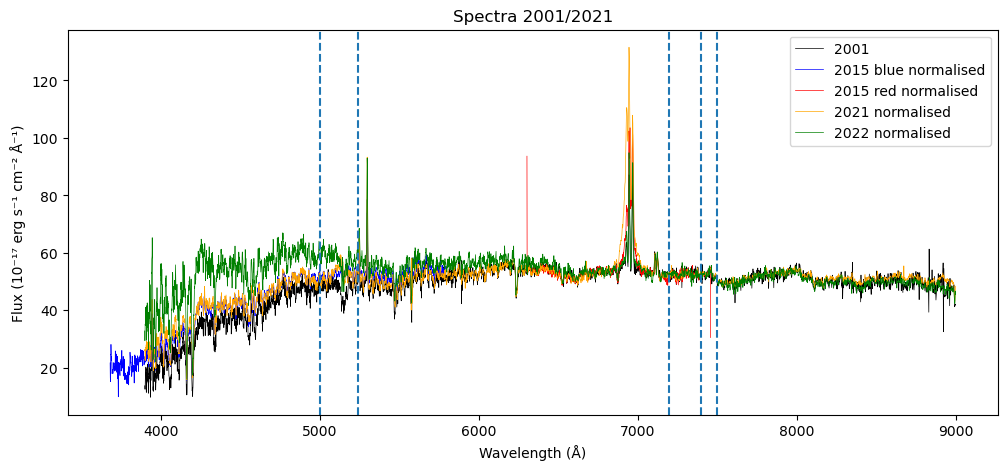

In [ ]:
##now to normalise each one and calculate a new difference spectrum
nidx_22 = np.where((lam22 > 7200) & (lam22 < 7500))
sec_22 = flux22[nidx_22]
mean_22 = np.mean(sec_22)

nidx_21 = np.where((lam21 > 7200) & (lam21 < 7500))  #7200-7500A is a section with no significant spectral lines - baseline seciton
sec_21 = flux21[nidx_21]
mean_21 = np.mean(sec_21)

nidx_15_blue = np.where((lam15_blue > 5000) & (lam15_blue < 5240))
sec_15_blue = flux15_blue[nidx_15_blue]
mean_15_blue = np.mean(sec_15_blue)

nidx_15_red = np.where((lam15_red > 7200) & (lam15_red < 7400))
sec_15_red = flux15_red[nidx_15_red]
mean_15_red = np.mean(sec_15_red)

nidx_01 = np.where((lam01 > 7200) & (lam01 < 7500))
sec_01 = flux01[nidx_01]
mean_01 = np.mean(sec_01)

ratio_22_01 = mean_01 / mean_22
ratio_21_01 = mean_01 / mean_21
ratio_15_blue_01 = mean_01 / mean_15_blue # red instead?
ratio_15_red_01 = mean_01 / mean_15_red

norm15_blue = flux15_blue * ratio_15_blue_01
norm15_red = flux15_red * ratio_15_red_01
norm21 = flux21 * ratio_21_01
norm22 = flux22 * ratio_22_01


# accounts for normalization
a = mean_21 / mean_01
var_norm01 = (a**2) * var01

#plotting normalised spectra
plt.clf()
plt.figure(figsize=FIGURE_SIZE)
plt.plot(lam01, flux01, color='black', label='2001', lw = LINEWIDTH)
plt.plot(lam15_blue, norm15_blue, color='blue', label='2015 blue normalised', lw = LINEWIDTH)
plt.plot(lam15_red, norm15_red, color='red', label='2015 red normalised', lw = LINEWIDTH)
plt.plot(lam21, norm21, color='orange', label='2021 normalised', lw = LINEWIDTH)
plt.plot(lam22, norm22, color='green', label='2022 normalised', lw = LINEWIDTH)
plt.axvline(7200, linestyle='--')
plt.axvline(7400, linestyle='--')
plt.axvline(7500, linestyle='--')
plt.axvline(5000, linestyle='--')
plt.axvline(5240, linestyle='--')
plt.xlabel("Wavelength (Å)")
plt.ylabel(SFD_Y_AX_LABEL)
plt.title("Spectra 2001/2021")
plt.legend()
plt.show()